In [92]:
# df.to_pickle('dataset_lcforest_LOF10_bin30_th3_1km_noprior_ta.pkl')

In [2]:
from scripts.parallel_blocks import *
import pandas as pd

df = pd.read_pickle('dataset_lcforest_mahal22_bin15_th3_fancy1km_noprior_ta.pkl')

df.pg.mean()

6.0306700875070405

### This can be used to adjust dataframes with a new outlier method or regression method.

In [12]:
from scripts.parallel_blocks import *
import pandas as pd

df_ = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy1km_noprior_ta.pkl')

# Create a column to fill later
df_['outlier'] = np.nan

# Grouping keys
group_keys = ['camera','date','lat','lon']
i=0
# Iterate over each group
for keys, test_plot in df_.groupby(group_keys):
    i+=1
    test_plot = test_plot.copy()

    try:
        coefs, _, test = df_odr(test_plot, outlier_removal=0.22, w=[1, 0.25])

        # Ensure index alignment for merging
        test_plot['outlier'] = test['Outlier'].values

        # Set the values back in the original df using index
        df_.loc[test_plot.index, 'outlier'] = test_plot['outlier']

        indices_to_insert = [i for i in range(1,7) if i not in test['beam'].unique()]

        for index in indices_to_insert:
            coefs = np.insert(coefs, index, None)

        if np.all(np.isnan([coefs[1],coefs[3],coefs[5]])):
            y_strong = np.nan
        else:
            y_strong = np.nanmean([coefs[1],coefs[3],coefs[5]])
            y_strong_max = np.nanmax([coefs[1],coefs[3],coefs[5]])
            
        if np.all(np.isnan([coefs[2],coefs[4],coefs[6]])):
            y_weak = np.nan
        else:
            y_weak = np.nanmean([coefs[2],coefs[4],coefs[6]])
            y_weak_max = np.nanmax([coefs[2],coefs[4],coefs[6]])
            
        if np.any(np.isnan([y_strong, y_weak])):
            pv_ratio_mean = np.nan
            pv_ratio_max = np.nan
        else:
            pv_ratio_mean = y_strong/y_weak
            pv_ratio_max = y_strong_max/y_weak_max
        
        y_intercept_dict = {1: coefs[1], 2: coefs[2], 3: coefs[3], 4: coefs[4], 5: coefs[5], 6: coefs[6]}
        x_intercept_dict = {1: -coefs[1]/coefs[0], 2: -coefs[2]/coefs[0], 3: -coefs[3]/coefs[0], 4: -coefs[4]/coefs[0],
                           5: -coefs[5]/coefs[0], 6: -coefs[6]/coefs[0]}

        df_.loc[test_plot.index,'pvpg'] = -coefs[0]
        df_.loc[test_plot.index,'pv'] = test_plot['beam'].map(y_intercept_dict)
        df_.loc[test_plot.index,'pg'] = test_plot['beam'].map(x_intercept_dict)
        df_.loc[test_plot.index,'pv_ratio_max'] = pv_ratio_max
        df_.loc[test_plot.index,'pv_ratio_mean'] = pv_ratio_mean

    except Exception as e:
        print(f"Skipping group {keys} due to error: {e}")
        continue

    # print(params)
    # print(test_plot)
    # print(test)

# All 18 Sites!

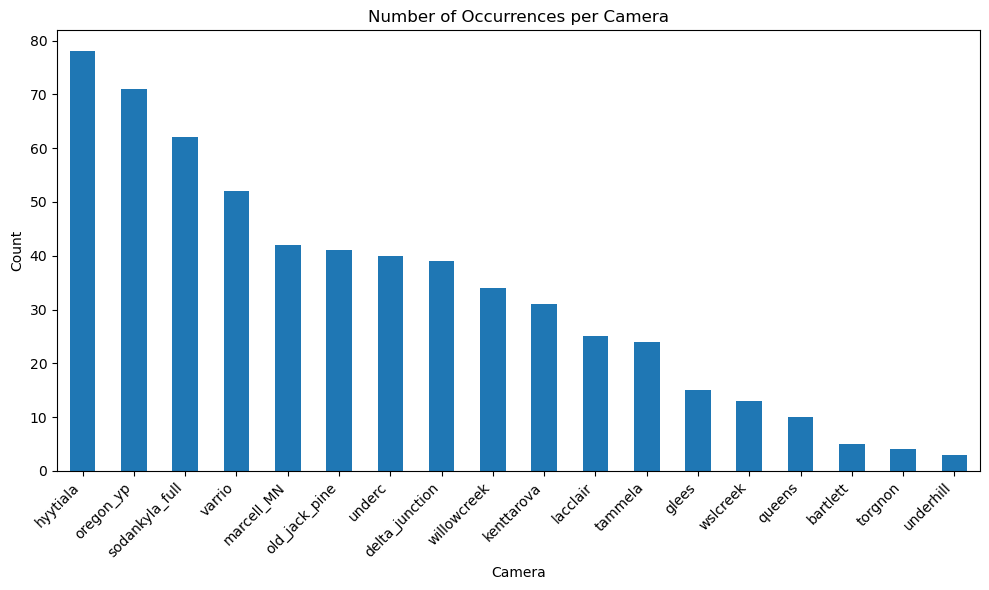

In [18]:
# Assuming your dataframe is called `data`
counts = data['camera'].value_counts()

plt.figure(figsize=(10, 6))
counts.plot(kind='bar')
plt.xlabel('Camera')
plt.ylabel('Count')
plt.title('Number of Occurrences per Camera')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

1819


/tmp/ipykernel_2419834/1258270984.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})


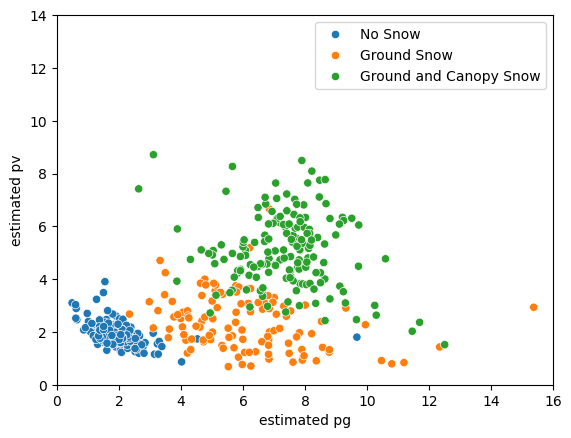

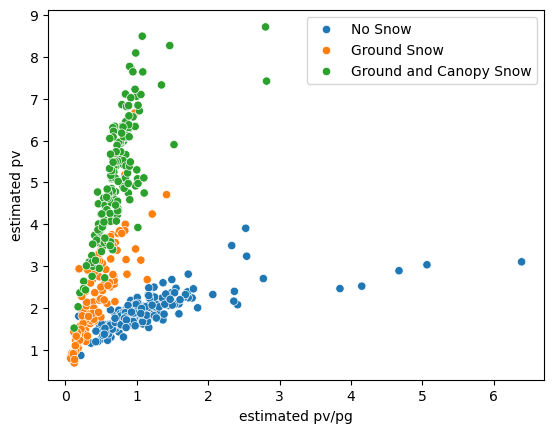

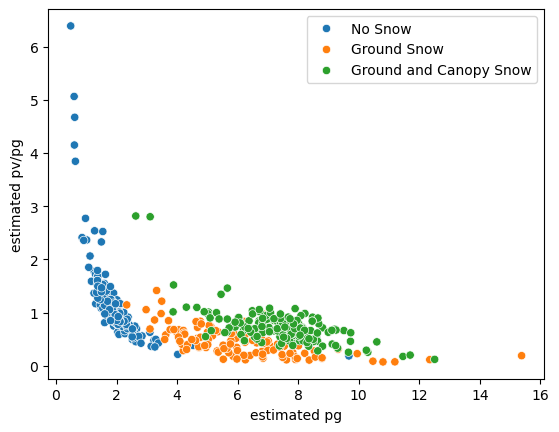

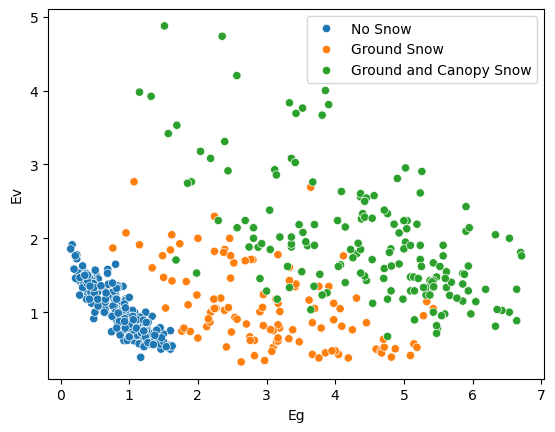

In [1]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy1km_noprior_ta_reclassified.pkl')
# df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy750m_noprior_ta.pkl')

# df = df_.copy()
# print(df)
# mask = df['beam'] == 3
# df.loc[mask, ['pv','pg','Ev','Eg']] /= 0.85

# First create masked columns
df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier'] == 1), df['Ev'], np.nan)
df['Eg_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'Eg_weak': 'median',
    'Ev_weak': 'median',
    'data_quantity': 'max',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
print(len(df_grouped[((df_grouped['FSC'] <= 0.05)|(df_grouped['FSC'] >= 0.95))]))
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
data = df_grouped[((df_grouped['FSC'] <= 0.05)|(df_grouped['FSC'] >= 0.95))
    # &((df_grouped['TreeSnow'] <= 0.05)|(df_grouped['TreeSnow'] >= 0.95))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)
    # &(df_grouped['pv_ratio_mean'] >= 1.2)
    &(df_grouped['Eg_strong']/df_grouped['Eg_weak'] >= 1.1)#&(df_grouped['Ev_strong']/df_grouped['Ev_weak'] >= 1.1)
    &((df_grouped['layer_flag'] <= .7)&(df_grouped['msw_flag'] < 0.2))&(df_grouped['data_quantity'] >= 27)]
data.loc[:, 'JointSnow'] = data['JointSnow'].apply(lambda x: np.round(x))

data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
plt.xlim(0,16)
plt.ylim(0,14)
# plt.plot([4.2,0],[0,9],'r--') #LOF10_bin20_DW 570 points
# plt.plot([5,0],[0,7.5],'r--') #LOF10_bin30_DW 596 points
                                #LOF10_bin20 578 points
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pvpg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pv/pg')
plt.ylabel('estimated pv')
# plt.xlim(0,3)
# plt.ylim(0,12)
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pvpg', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv/pg')
# plt.xlim(0,20)
# plt.ylim(0,20)
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='Eg_strong', y='Ev_strong', hue='Conditions')#, size='data_quantity')
plt.xlabel('Eg')
plt.ylabel('Ev')
# plt.xlim(0,20)
# plt.ylim(0,20)
# plt.plot([2.5,0],[0,2.5],'r--') #LOF10_bin20 570 points
# plt.plot([2.5,0],[0,2.5],'r--') #LOF10_bin30 596 points
plt.legend(loc='best')
plt.show()

#### Logistic Regression

/tmp/ipykernel_2419834/3963482905.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)


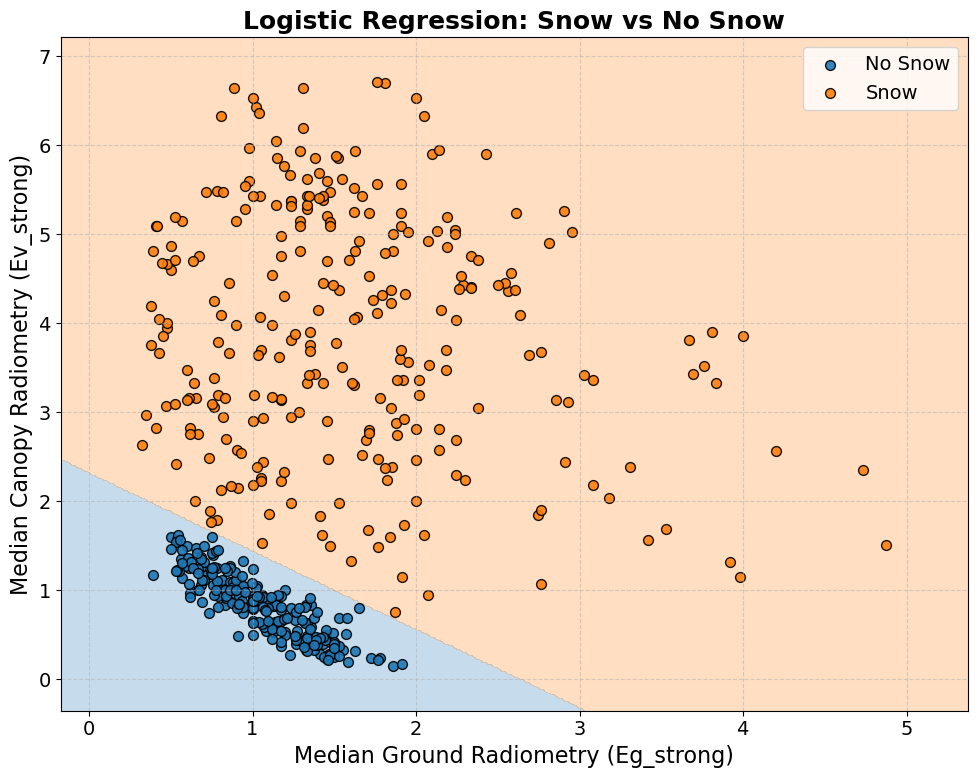

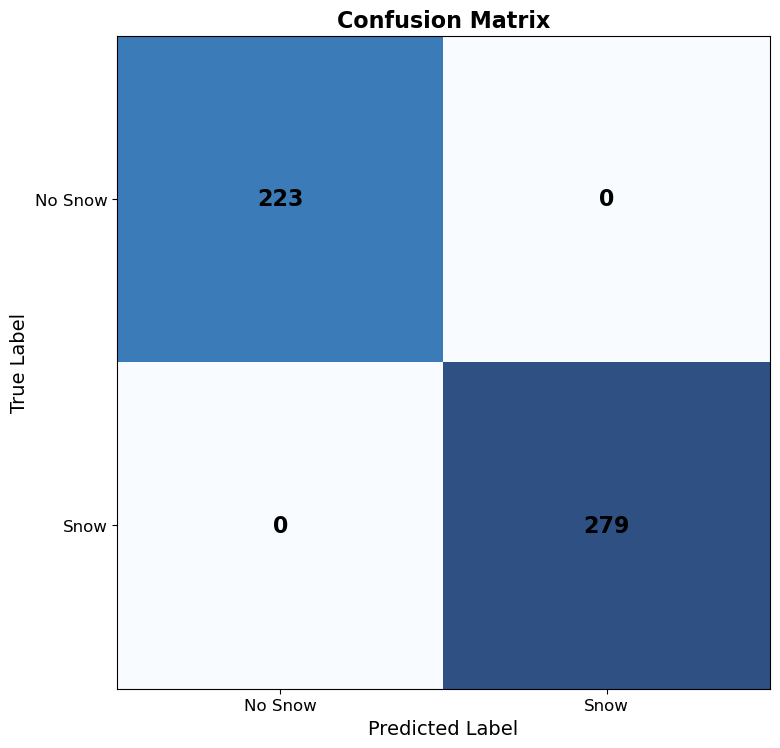

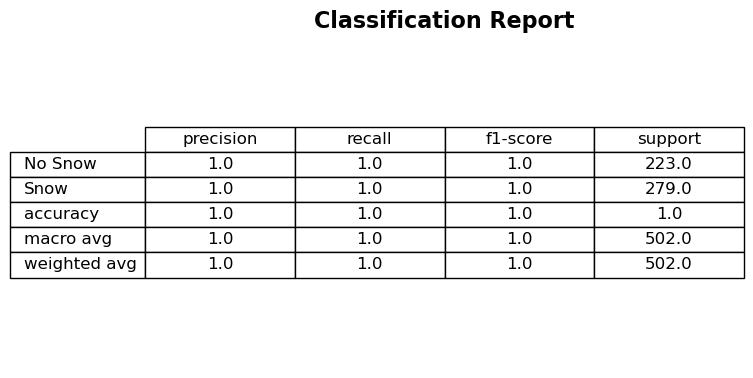

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# --- Setup ---
features = ['Ev_strong', 'Eg_strong']
target = 'JointSnowBinary'
data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)

X = data[features].values
y = data[target].values
labels = ['No Snow', 'Snow']

# --- Fit model ---
model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, penalty=None)
model.fit(X, y)
y_pred = model.predict(X)

# --- Decision boundary plot ---
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict(grid).reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 14})

plt.contourf(xx, yy, Z, alpha=0.25, levels=[-0.5, 0.5, 1.5], colors=['#1f77b4', '#ff7f0e'])

plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], 
            edgecolor='k', label='No Snow', color='#1f77b4', s=50, alpha=0.9)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], 
            edgecolor='k', label='Snow', color='#ff7f0e', s=50, alpha=0.9)

plt.xlabel('Median Ground Radiometry (Eg_strong)', fontsize=16)
plt.ylabel('Median Canopy Radiometry (Ev_strong)', fontsize=16)
plt.title('Logistic Regression: Snow vs No Snow', fontsize=18, weight='bold')
plt.legend(fontsize=14, loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig('snow_vs_nosnow_logreg_poster.svg', bbox_inches='tight')
# plt.savefig('snow_vs_nosnow_logreg_poster.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Confusion Matrix Plot ---
cm = confusion_matrix(y, y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, cmap='Blues', alpha=0.85)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=16, fontweight='bold', color='black')

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.set_title('Confusion Matrix', fontsize=16, weight='bold')
plt.tight_layout()
# plt.savefig("confusion_matrix_poster.svg", bbox_inches='tight')
# plt.savefig("confusion_matrix_poster.png", dpi=300, bbox_inches='tight')
plt.show()

# --- Classification Report Table ---
report_dict = classification_report(y, y_pred, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(2)

fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')
table = ax.table(cellText=report_df.values,
                 colLabels=report_df.columns,
                 rowLabels=report_df.index,
                 loc='center',
                 cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.4)
plt.title('Classification Report', fontsize=16, weight='bold')
plt.tight_layout()
# plt.savefig("classification_report_poster.svg", bbox_inches='tight')
# plt.savefig("classification_report_poster.png", dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_2829881/2979659657.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['JointSnowRounded'] = data['JointSnow'].round().astype(int)
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


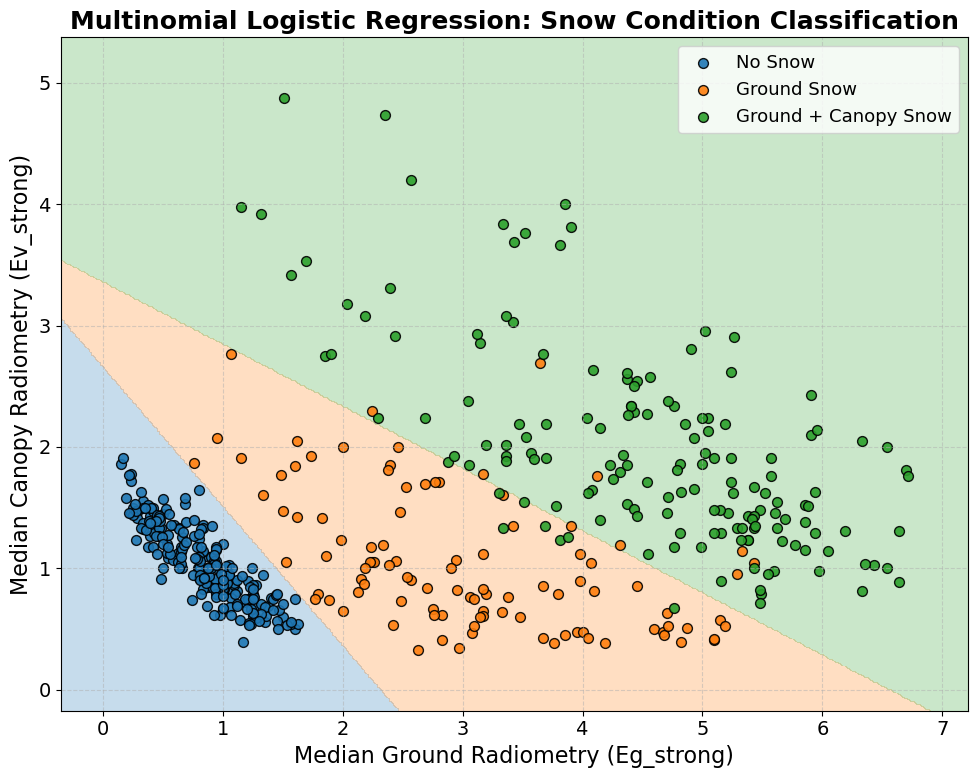

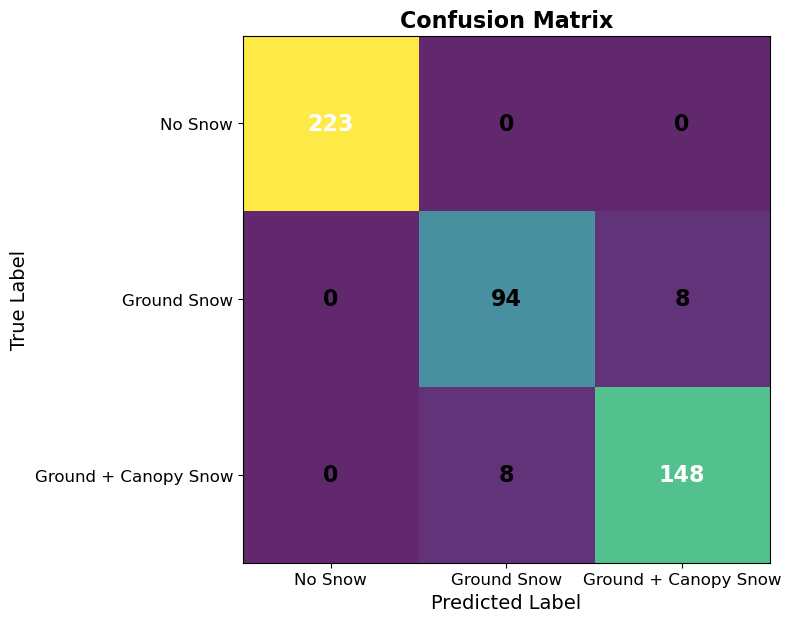

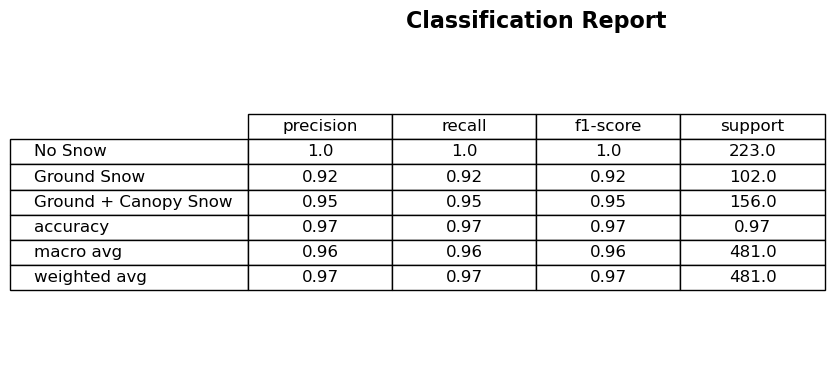

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# --- Prepare Data ---
data['JointSnowRounded'] = data['JointSnow'].round().astype(int)
features = ['Eg_strong', 'Ev_strong']
target = 'JointSnowRounded'

X = data[features].values
y = data[target].values

# --- Fit Multinomial Logistic Regression ---
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42, penalty=None)
model.fit(X, y)
y_pred = model.predict(X)

# --- Decision Boundary Plot ---
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict(grid).reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 14})

# Define labels and colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green
labels_str = ['No Snow', 'Ground Snow', 'Ground + Canopy Snow']

# Background decision regions
plt.contourf(xx, yy, Z, alpha=0.25, levels=[-0.5, 0.5, 1.5, 2.5], colors=colors)

# Data points
for cls in [0, 1, 2]:
    mask = y == cls
    plt.scatter(X[mask, 0], X[mask, 1], s=50, color=colors[cls], edgecolor='k', label=labels_str[cls], alpha=0.9)

plt.xlabel('Median Ground Radiometry (Eg_strong)', fontsize=16)
plt.ylabel('Median Canopy Radiometry (Ev_strong)', fontsize=16)
plt.title('Multinomial Logistic Regression: Snow Condition Classification', fontsize=18, weight='bold')
plt.legend(fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('multinomial_logreg_decision_boundary.svg', bbox_inches='tight')
plt.savefig('multinomial_logreg_decision_boundary.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Confusion Matrix Plot ---
cm = confusion_matrix(y, y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, cmap='viridis', alpha=0.85)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=16, fontweight='bold', color='white' if cm[i, j] > cm.max()/2 else 'black')

ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_xticklabels(labels_str, fontsize=12)
ax.set_yticklabels(labels_str, fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.set_title('Confusion Matrix', fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig("multinomial_logreg_confusion_matrix.svg", bbox_inches='tight')
plt.savefig("multinomial_logreg_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# --- Classification Report Table ---
report_dict = classification_report(y, y_pred, target_names=labels_str, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(2)

fig, ax = plt.subplots(figsize=(9, 4))
ax.axis('off')
table = ax.table(cellText=report_df.values,
                 colLabels=report_df.columns,
                 rowLabels=report_df.index,
                 loc='center',
                 cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.4)
plt.title('Classification Report', fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig("multinomial_logreg_classification_report.svg", bbox_inches='tight')
plt.savefig("multinomial_logreg_classification_report.png", dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_2829881/4280793764.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['JointSnowRounded'] = data['JointSnow'].round().astype(int)


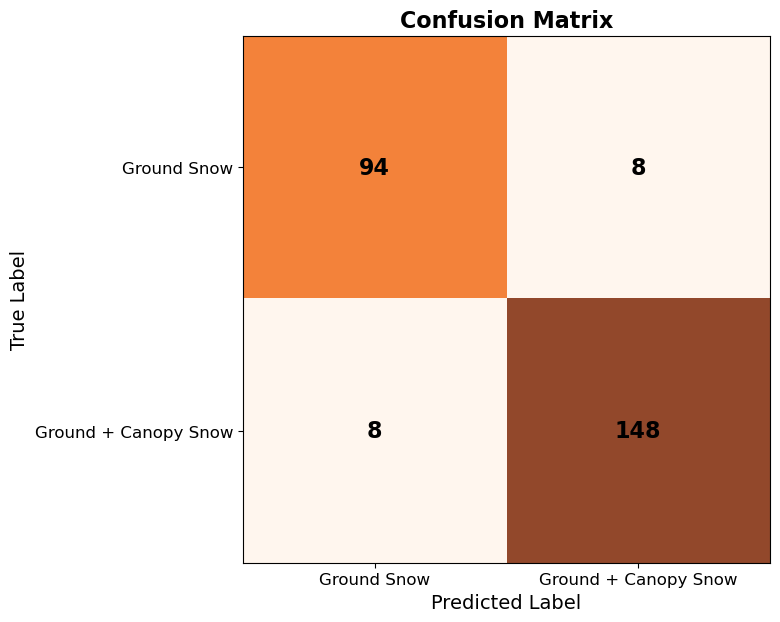

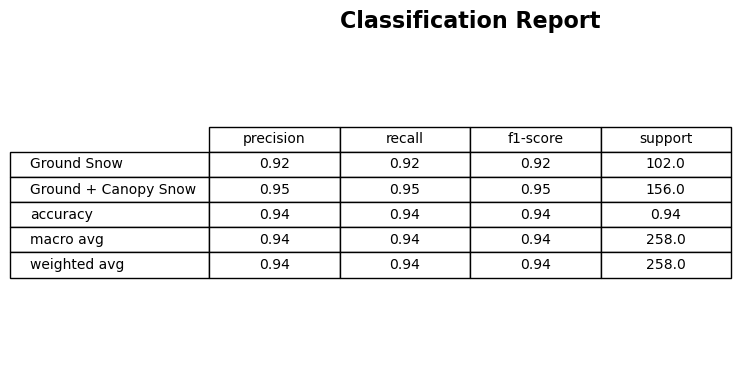

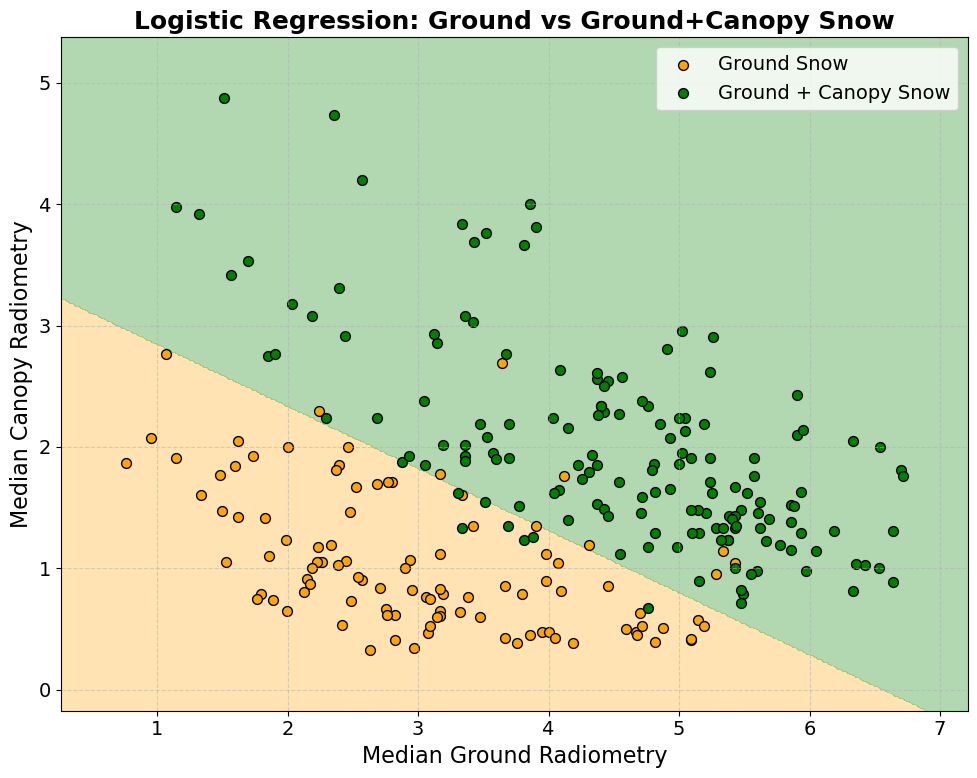

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Round to get 3-class labels
data['JointSnowRounded'] = data['JointSnow'].round().astype(int)

features = ['Eg_strong', 'Ev_strong']
target = 'JointSnowRounded'

# Filter for class 1 and 2 only
mask = data['JointSnowRounded'].isin([1, 2])
data_filtered = data[mask].copy()

X = data_filtered[features].values
y = data_filtered[target].replace({1: 0, 2: 1}).values  # 0 = Ground Snow, 1 = Ground+Canopy Snow

# Fit model
model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, penalty=None)
model.fit(X, y)

# Predict
y_pred = model.predict(X)

# --- Confusion Matrix Plot ---
cm = confusion_matrix(y, y_pred)
labels = ['Ground Snow', 'Ground + Canopy Snow']
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, cmap='Oranges', alpha=0.85)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=16, fontweight='bold', color='black')

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.set_title('Confusion Matrix', fontsize=16, weight='bold')
# plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
# plt.savefig('confusion_matrix_ground_vs_canopy.png', dpi=300, bbox_inches='tight')
plt.savefig('confusion_matrix_ground_vs_canopy.svg', bbox_inches='tight')
plt.show()

# --- Classification Report Plot ---
report_dict = classification_report(y, y_pred, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(2)

fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')
table = ax.table(cellText=report_df.values,
                 colLabels=report_df.columns,
                 rowLabels=report_df.index,
                 loc='center',
                 cellLoc='center')
table.auto_set_font_size(True)
table.set_fontsize(10)
table.scale(1.2, 1.4)
plt.title('Classification Report', fontsize=16, weight='bold')
plt.tight_layout()
# plt.savefig('classification_report_ground_vs_canopy.png', dpi=300, bbox_inches='tight')
plt.savefig('classification_report_ground_vs_canopy.svg', bbox_inches='tight')
plt.show()

# --- Decision Boundary Plot ---
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict(grid).reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 14})

plt.contourf(xx, yy, Z, alpha=0.3, levels=[-0.5, 0.5, 1.5], colors=['orange', 'green'])

plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], s=50, edgecolor='k', color='orange', label='Ground Snow')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], s=50, edgecolor='k', color='green', label='Ground + Canopy Snow')

plt.xlabel('Median Ground Radiometry', fontsize=16)
plt.ylabel('Median Canopy Radiometry', fontsize=16)
plt.title('Logistic Regression: Ground vs Ground+Canopy Snow', fontsize=18, weight='bold')
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig('ground_vs_canopy_logreg_poster.png', dpi=300, bbox_inches='tight')
plt.savefig('ground_vs_canopy_logreg_poster.svg', bbox_inches='tight')
plt.show()


#### Linear function of pv and pg

In [16]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Assuming your dataframe is called df
# features = ['pvpg', 'pv', 'pg', 'snr', 'pv_ratio_mean', 'pv_ratio_max']
features = ['pv', 'pg', 'pvpg']#,'Ev_strong','Eg_strong',]
target = 'JointSnowBinary'

data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)

X = data[features]
y = data[target]

# Optional: standardize the features (helps logistic regression perform better)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression on all data
model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, penalty=None)
model.fit(X_scaled, y)

# Predict on the same data (since you said to use all data)
y_pred = model.predict(X_scaled)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Get boolean mask of incorrect predictions
incorrect_mask = y != y_pred

# Optionally convert y to numpy array if needed
# y = y.to_numpy()

# Get the misclassified rows from the original dataframe
misclassified = data[incorrect_mask]

# Add true and predicted labels to the misclassified DataFrame for inspection
misclassified = misclassified.copy()
misclassified['TrueLabel'] = y[incorrect_mask]
misclassified['PredictedLabel'] = y_pred[incorrect_mask]

# Show the result
misclassified.sort_values(['JointSnow','camera','date'])

Confusion Matrix:
[[282   4]
 [ 12 257]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       286
           1       0.98      0.96      0.97       269

    accuracy                           0.97       555
   macro avg       0.97      0.97      0.97       555
weighted avg       0.97      0.97      0.97       555



/tmp/ipykernel_362537/3029202463.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)


camera        date        lat         lon      pvpg        pv  \
2676          underc  07/05/2019  46.227143  -89.579656  0.083312  1.323971   
2854       underhill  07/11/2021  44.527252  -72.846087  0.555310  2.149833   
3117     willowcreek  05/09/2020  45.817261  -90.051450  0.174904  1.800639   
3241     willowcreek  15/06/2019  45.839784  -90.060042  0.137783  1.795168   
95          bartlett  31/01/2021  44.075861  -71.243271  3.376928  3.759916   
347   delta_junction  30/04/2022  63.869839 -145.788221  0.436778  1.901914   
348   delta_junction  30/04/2022  63.874343 -145.789414  0.420834  1.805265   
1130      marcell_MN  20/03/2022  47.538684  -93.439705  0.325965  1.480065   
1263      marcell_MN  30/10/2020  47.489134  -93.474873  0.376562  1.505988   
3242     willowcreek  28/02/2024  45.772216  -90.076248  0.113407  0.854146   
3243     willowcreek  28/02/2024  45.772216  -90.034834  0.814331  2.117342   
3253     willowcreek  28/02/2024  45.794739  -90.037909  0.178632  0.970830   
3255     willowcreek  28/02/2024  45.799243  -90.038521  0.333354  1.334884   
3261     willowcreek  28/02/2024  45.812757  -90.040354  0.116023  0.724476   
3266     willowcreek  28/02/2024  45.826270  -90.083699  0.080699  0.702009   
3267     willowcreek  28/02/2024  45.826270  -90.042240  0.076953  0.585129   

             pg  Eg_strong  Ev_strong  data_quantity  ...  layer_flag  \
2676  15.891767   4.313725   0.904977      23.000000  ...         0.0   
2854   3.871414   0.816176   1.552778      23.620690  ...         0.0   
3117  10.294989   1.578947   1.571429      31.129032  ...         0.0   
3241  13.028996   2.441176   1.512605      32.000000  ...         0.0   
95     1.113413   0.533333   1.866667      22.714286  ...         0.0   
347    4.354419   3.193277   0.470588      23.391304  ...         0.0   
348    4.289736   2.043344   0.825593      25.980392  ...         0.0   
1130   4.540564   1.872368   0.830144      22.409091  ...         0.0   
1263   3.999315   1.564474   0.973684      24.459459  ...         0.0   
3242   7.531654   3.413095   0.418831      28.529412  ...         0.0   
3243   2.600100   1.300310   0.899654      25.681818  ...         0.0   
3253   5.434809   1.857585   0.622837      25.782609  ...         0.0   
3255   4.004407   1.799308   0.808824      22.714286  ...         0.0   
3261   6.244214   2.913165   0.392157      22.250000  ...         0.0   
3266   8.699141   3.772727   0.380952      25.368421  ...         0.0   
3267   7.603699   3.157895   0.294118      22.500000  ...         0.0   

      file_index  msw_flag  pv_ratio_mean  pv_ratio_max  JointSnow  \
2676         0.0       0.0            NaN           NaN        0.0   
2854         5.0       0.0       1.415580      1.415580        0.0   
3117         7.0       0.0       1.975942      1.975942        0.0   
3241         3.0       0.0            NaN           NaN        0.0   
95           6.0       0.0       1.182391      1.182391        1.0   
347         19.0       0.0       1.642809      1.642809        1.0   
348         19.0       0.0       1.975319      1.975319        1.0   
1130        16.0       0.0       1.832224      1.832224        1.0   
1263         9.0       0.0       1.824053      1.824053        1.0   
3242        17.0       0.0       1.702053      1.702053        1.0   
3243        17.0       0.0       1.820944      1.820944        1.0   
3253        17.0       0.0       1.155743      1.155743        1.0   
3255        17.0       0.0       1.879581      1.879581        1.0   
3261        17.0       0.0       1.903968      1.903968        1.0   
3266        17.0       0.0       1.615515      1.615515        1.0   
3267        17.0       0.0       1.665985      1.665985        1.0   

       Conditions  JointSnowBinary  TrueLabel PredictedLabel  
2676      No Snow                0          0              1  
2854      No Snow                0          0              1  
3117      No Snow                0          0   

# Plotting ATL08 from the Dataframe

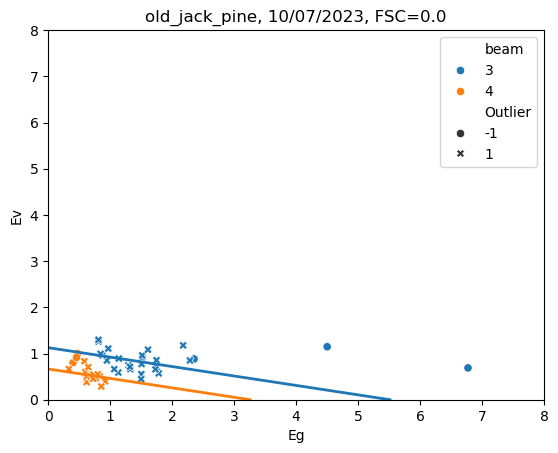

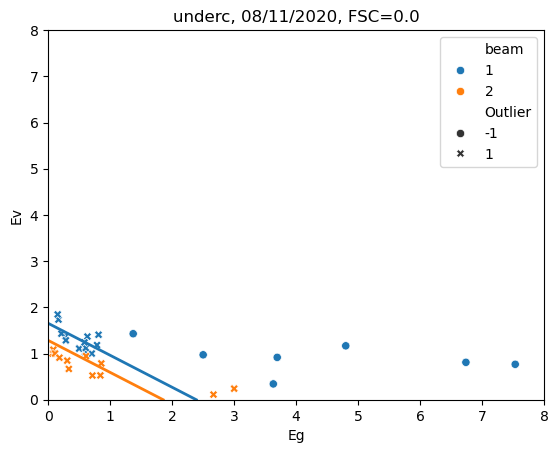

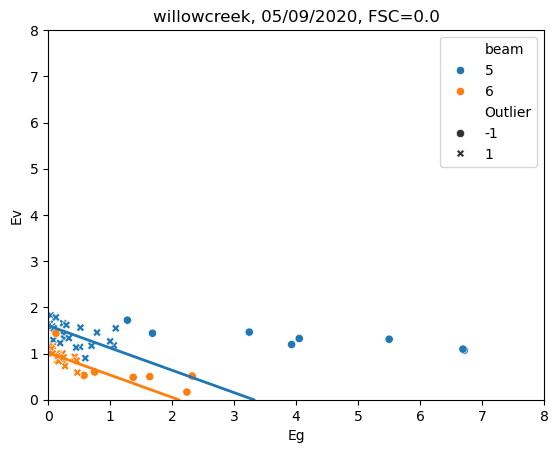

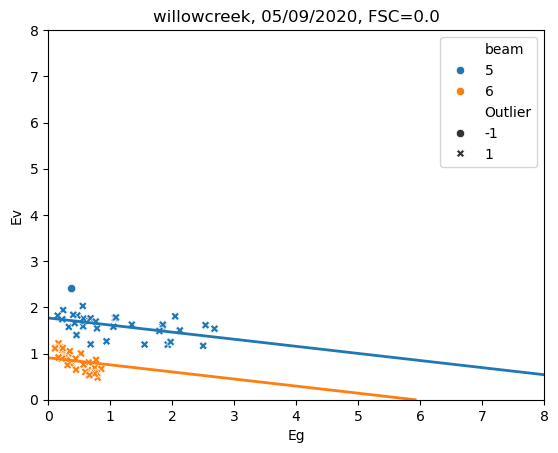

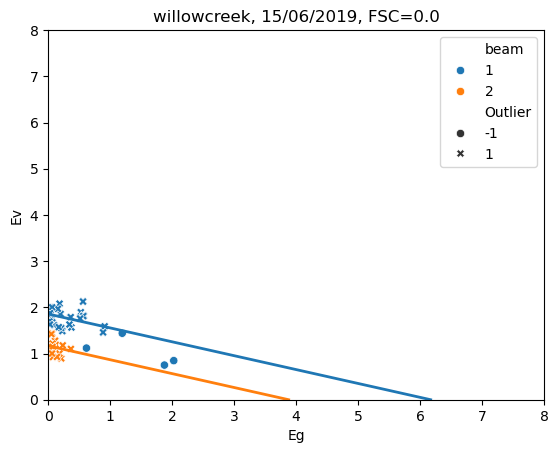

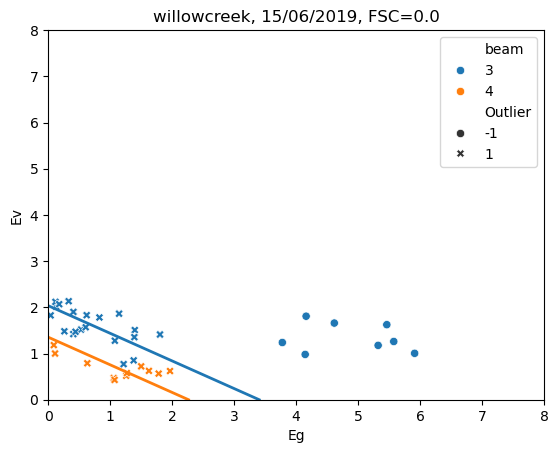

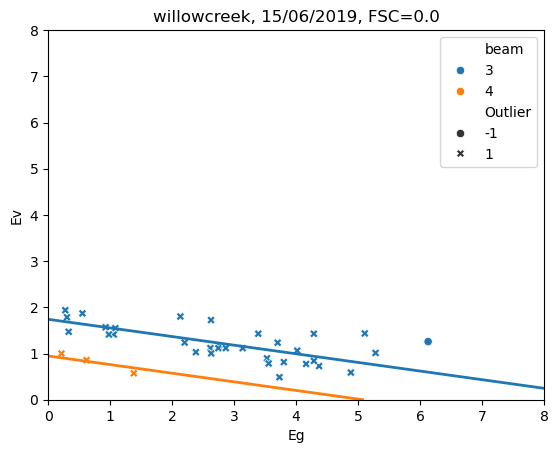

In [11]:
from scripts.parallel_blocks import *
    
# misclassified.columns
for idx, row in misclassified.iterrows():
    if row['FSC'] <= 0.05:
        plt.figure()
        plt.title(f"{row['camera']}, {row['date']}, FSC={row['FSC']}")
        
        test_plot = df[(df['camera'] == row['camera']) &
                       (df['date'] == row['date']) &
                       (df['lon'] == row['lon']) &
                       (df['lat'] == row['lat'])].copy()

        params, _, test = df_odr(test_plot, outlier_removal=10,w=[1, 0.25])

        # print(test)

        # Get sorted unique beams (hue order used by seaborn)
        beam_order = sorted(test['beam'].unique())

        # Create mapping from beam label to tab10 color
        tab10 = cm.get_cmap('tab10')
        color_map = {beam: tab10(i) for i, beam in enumerate(beam_order)}

        # Plot with fixed hue order and palette
        sns.scatterplot(data=test, x='Eg', y='Ev', hue='beam', style='Outlier',
                        hue_order=beam_order, palette=color_map)

        # Plot ODR lines in matching colors
        for b, beam in zip(params[1:], beam_order):
            plt.plot([0, -b / params[0]], [b, 0], color=color_map[beam], linewidth=2)

        plt.xlim(0, 8)
        plt.ylim(0, 8)
        plt.legend()
        plt.show()

        # break

# Fractional

/tmp/ipykernel_2419834/3639832409.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)


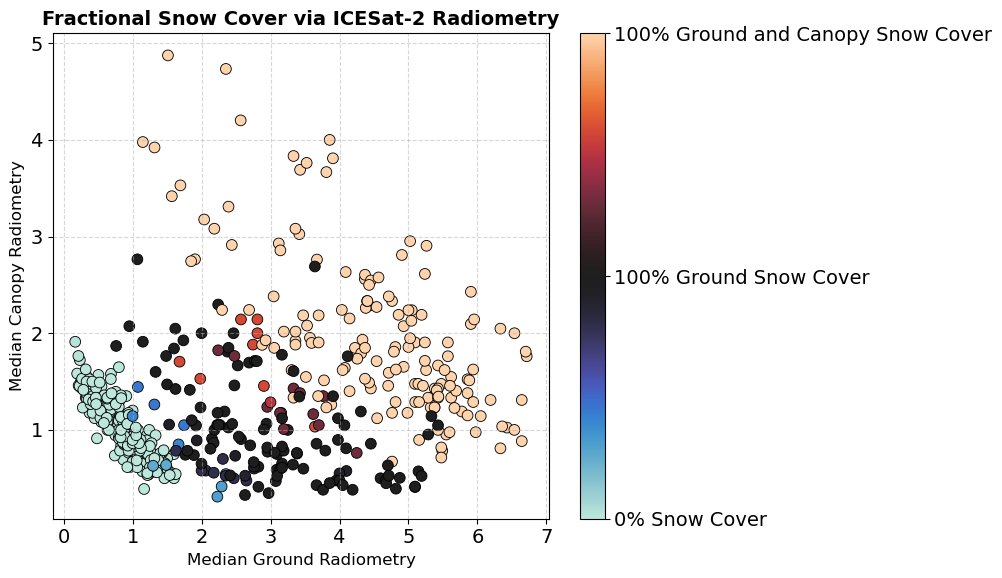

In [3]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy1km_noprior_ta_reclassified.pkl')
# print(df.columns)

df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Ev'], np.nan)
df['Eg_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'Eg_weak': 'median',
    'Ev_weak': 'median',
    'data_quantity': 'max',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
frac_data = df_grouped[((df_grouped['FSC'] >= 0.00)&(df_grouped['FSC'] <= 1.00))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)
    # &(df_grouped['pv_ratio_mean'] >= 1.2)
    &(df_grouped['Eg_strong']/df_grouped['Eg_weak'] >= 1.2)#&(df_grouped['Ev_strong']/df_grouped['Ev_weak'] >= 1.1)
    &((df_grouped['layer_flag'] <= .7)&(df_grouped['msw_flag'] < 0.2))&(df_grouped['data_quantity'] >= 27)]
frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)

plt.figure(figsize=(10, 6))
ax = plt.gca()
scatter = sns.scatterplot(
    data=frac_data.sort_values('FSC'),
    x='Eg_strong', y='Ev_strong',
    hue='JointSnow', palette='icefire', edgecolor='black', s=60, ax=ax, legend=False
)

# Add manual colorbar
norm = plt.Normalize(0, 2)
sm = plt.cm.ScalarMappable(cmap='icefire', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label('Snow Cover Category', fontsize=12)
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['0% Snow Cover', '100% Ground Snow Cover', '100% Ground and Canopy Snow Cover'])

# Set axes and title
plt.xlabel('Median Ground Radiometry', fontsize=12)
plt.ylabel('Median Canopy Radiometry', fontsize=12)
plt.title('Fractional Snow Cover via ICESat-2 Radiometry', fontsize=14, weight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig('poster_FSC_icefire.svg')
plt.show()


/tmp/ipykernel_417899/1080831255.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)


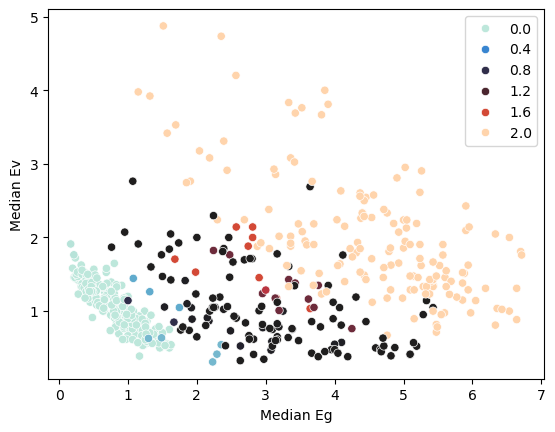

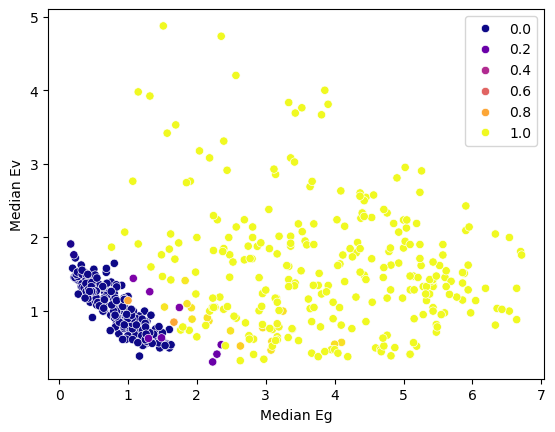

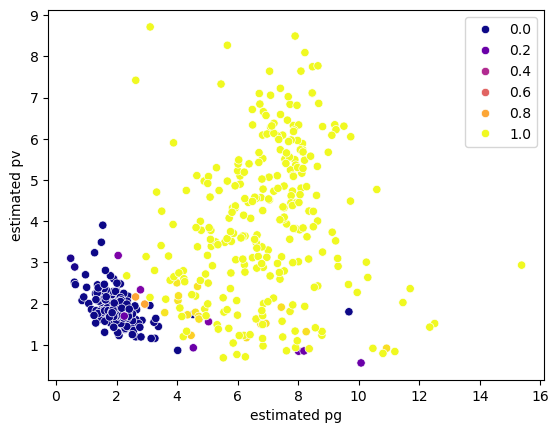

513


camera        date        lat         lon      pvpg        pv  \
1008       oregon_yp  22/10/2020  44.310286 -121.600105  0.791895  1.717219   
1214  sodankyla_full  10/06/2021  67.366338   26.552934  0.784646  1.583371   
1215  sodankyla_full  10/06/2021  67.375347   26.555926  1.238355  1.968960   
1216  sodankyla_full  10/06/2021  67.384356   26.558736  1.103549  1.813521   
1217  sodankyla_full  10/06/2021  67.393365   26.561703  1.528779  2.363341   
...              ...         ...        ...         ...       ...       ...   
148   delta_junction  26/01/2024  63.903623 -145.747408  0.487531  3.823556   
149   delta_junction  26/01/2024  63.903623 -145.680798  0.669049  4.145079   
151   delta_junction  26/01/2024  63.912632 -145.683011  0.725200  4.216349   
1932        wslcreek  26/01/2022  39.877886 -105.892015  1.520353  5.902035   
189   delta_junction  29/10/2022  63.849568 -145.684570  0.461507  4.487948   

            pg  Eg_strong  Ev_strong   Eg_weak  ...         snr  FSC  \
1008  2.168494   1.461842   0.500000  0.713636  ...    1.221388  0.0   
1214  2.017942   0.930952   0.837719  0.428571  ...    1.414029  0.0   
1215  1.589980   0.882353   0.933333  0.500000  ...    1.231196  0.0   
1216  1.643354   1.058824   0.684211  0.500000  ...    1.398293  0.0   
1217  1.545901   1.000000   0.862500  0.600000  ...    1.531685  0.0   
...        ...        ...        ...       ...  ...         ...  ...   
148   7.842690   5.975000   0.976190  1.736842  ...  159.178622  1.0   
149   6.195474   3.361345   1.921569  1.250980  ...  137.000886  1.0   
151   5.814051   2.689076   2.240896  1.000000  ...  137.145108  1.0   
1932  3.882015   1.317927   3.921569  0.285714  ...  238.532124  1.0   
189   9.724555   5.047619   2.238095  1.285714  ...  147.738420  1.0   

      TreeSnow  layer_flag  file_index  msw_flag  pv_ratio_mean  pv_ratio_max  \
1008       0.0    0.000000        11.0  0.085106       1.574397      1.574397   
1214       0.0    0.000000        16.0  0.000000       1.473088      1.473088   
1215       0.0    0.000000        16.0  0.000000       1.502292      1.502292   
1216       0.0    0.000000        16.0  0.000000       1.527379      1.527379   
1217       0.0    0.000000        16.0  0.000000       1.540921      1.540921   
...        ...         ...         ...       ...            ...           ...   
148        1.0    0.000000        31.0  0.000000       3.385618      3.385618   
149        1.0    0.000000        31.0  0.000000       3.028744      3.028744   
151        1.0    0.000000        31.0  0.000000       2.877390      2.877390   
1932       1.0    0.586207         9.0  0.000000       2.986628      2.986628   
189        1.0    0.000000        22.0  0.000000       3.317219      3.317219   

      JointSnow  JointSnowBinary  
1008        0.0              0.0  
1214        0.0              0.0  
1215        0.0              0.0  
1216        0.0              0.0  
1217        0.0              0.0  
...         ...              ...  
148         2.0              1.0  
149         2.0              1.0  
151         2.0              1.0  
1932        2.0              1.0  
189         2.0              1.0  

[513 rows x 22 columns]

In [1]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy1km_noprior_ta.pkl')
# print(df.columns)

df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Ev'], np.nan)
df['Eg_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'Eg_weak': 'median',
    'Ev_weak': 'median',
    'data_quantity': 'max',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
frac_data = df_grouped[((df_grouped['FSC'] >= 0.00)&(df_grouped['FSC'] <= 1.00))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)
    # &(df_grouped['pv_ratio_mean'] >= 1.2)
    &(df_grouped['Eg_strong']/df_grouped['Eg_weak'] >= 1.2)#&(df_grouped['Ev_strong']/df_grouped['Ev_weak'] >= 1.1)
    # &(df_grouped['date']!='18/04/2019')
    &((df_grouped['layer_flag'] <= .7)&(df_grouped['msw_flag'] < 0.2))&(df_grouped['data_quantity'] >= 27)]
frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='Eg_strong', y='Ev_strong', hue='JointSnow', palette='icefire')
plt.xlabel('Median Eg')
plt.ylabel('Median Ev')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='Eg_strong', y='Ev_strong', hue='JointSnowBinary', palette='plasma')
plt.xlabel('Median Eg')
plt.ylabel('Median Ev')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='pg', y='pv', hue='JointSnowBinary', palette='plasma')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

print(len(frac_data))
frac_data.sort_values('FSC')

/tmp/ipykernel_1729079/1651685768.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)


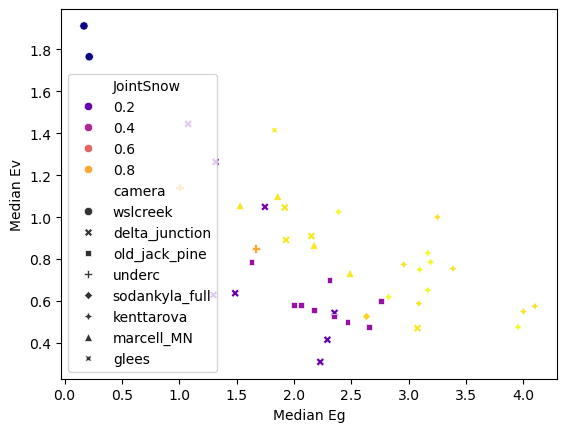

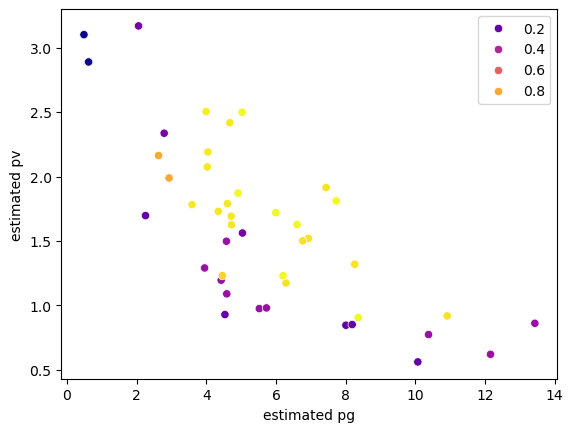

44


camera        date        lat         lon      pvpg        pv  \
1914        wslcreek  23/10/2023  39.913923 -105.903778  6.389692  3.100944   
1911        wslcreek  23/10/2023  39.895905 -105.905789  4.672310  2.888945   
71    delta_junction  02/05/2021  63.867586 -145.769149  0.105647  0.846117   
72    delta_junction  02/05/2021  63.876595 -145.771246  0.204834  0.928807   
73    delta_junction  02/05/2021  63.885605 -145.773318  0.055724  0.561393   
158   delta_junction  26/04/2024  63.876595 -145.756934  0.752970  1.696849   
152   delta_junction  26/04/2024  63.849568 -145.750302  0.103964  0.851402   
81    delta_junction  03/05/2020  63.876595 -145.805841  1.543325  3.168583   
86    delta_junction  03/05/2020  63.894614 -145.809919  0.310046  1.561783   
83    delta_junction  03/05/2020  63.885605 -145.807932  0.837430  2.335950   
830    old_jack_pine  18/04/2019  53.884768 -104.748556  0.074524  0.773714   
832    old_jack_pine  18/04/2019  53.893777 -104.749794  0.326606  1.290466   
834    old_jack_pine  18/04/2019  53.902786 -104.702380  0.064088  0.861068   
833    old_jack_pine  18/04/2019  53.893777 -104.700485  0.237569  1.089670   
839    old_jack_pine  18/04/2019  53.938823 -104.708216  0.176611  0.975215   
838    old_jack_pine  18/04/2019  53.929814 -104.706720  0.051006  0.620299   
837    old_jack_pine  18/04/2019  53.920805 -104.705257  0.171196  0.980445   
836    old_jack_pine  18/04/2019  53.911795 -104.703752  0.270104  1.195691   
840    old_jack_pine  18/04/2019  53.947832 -104.709710  0.327205  1.497914   
1490          underc  03/11/2023  46.256423  -89.542732  0.823199  2.163023   
1488          underc  03/11/2023  46.247414  -89.544000  0.678705  1.988547   
1327  sodankyla_full  25/04/2019  67.366338   26.677426  0.275939  1.231171   
497       kenttarova  07/05/2019  68.009806   24.296127  0.219299  1.520094   
489       kenttarova  07/05/2019  67.973769   24.152065  0.257323  1.914613   
493       kenttarova  07/05/2019  67.991788   24.223952  0.186701  1.174055   
492       kenttarova  07/05/2019  67.982778   24.226796  0.221780  1.500817   
486       kenttarova  07/05/2019  67.964760   24.154866  0.084135  0.918478   
498       kenttarova  07/05/2019  68.018815   24.294053  0.159696  1.319430   
201   delta_junction  30/04/2022  63.876595 -145.789911  0.514998  2.074235   
202   delta_junction  30/04/2022  63.885605 -145.792315  0.388734  1.790463   
200   delta_junction  30/04/2022  63.867586 -145.787644  0.344281  1.625753   
203   delta_junction  30/04/2022  63.894614 -145.794326  0.541602  2.190381   
720       marcell_MN  30/10/2020  47.500395  -93.473155  0.398223  1.729496   
716       marcell_MN  30/10/2020  47.473368  -93.477138  0.517070  2.417000   
718       marcell_MN  30/10/2020  47.482377  -93.475851  0.359007  1.692257   
719       marcell_MN  30/10/2020  47.491386  -93.474798  0.496297  1.781970   
267            glees  28/05/2023  41.359895 -106.214109  0.627306  2.504540   
536       kenttarova  25/05/2020  67.982778   24.217766  0.286985  1.719973   
537       kenttarova  25/05/2020  67.991788   24.220725  0.497106  2.498636   
535       kenttarova  25/05/2020  67.973769   24.214672  0.381058  1.871356   
540       kenttarova  25/05/2020  68.018815   24.151378  0.198234  1.229721   
538       kenttarova  25/05/2020  68.000797   24.223756  0.108291  0.905596   
533       kenttarova  25/05/2020  67.955751   24.208633  0.246409  1.627780   
534       kenttarova  25/05/2020  67.964760   24.211748  0.234296  1.810812   

             pg  Eg_strong  Ev_strong   Eg_weak  ...         snr   FSC  \
1914   0.485304   0.168067   1.911765  0.111111  ...    0.373098  0.02   
1911   0.618312   0.213904   1.764706  0.118056  ...    0.357741  0.02   
71     8.008945   2.352941   0.543344  0.944444  ...    0.866235  0.20   
72     4.534446   2.291022   0.415225  0.928571  ...    0.841385  0.20   
73    10.074529   2.229102   0.309598  0.883117  ...    0.859275  0.20   
158    2.25354

In [28]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy1km_noprior_ta.pkl')
# print(df.columns)

df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Ev'], np.nan)
df['Eg_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'Eg_weak': 'median',
    'Ev_weak': 'median',
    'data_quantity': 'max',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
frac_data = df_grouped[((df_grouped['FSC'] > 0.00)&(df_grouped['FSC'] < 1.00))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)
    # &(df_grouped['pv_ratio_mean'] >= 1.2)
    &(df_grouped['Eg_strong']/df_grouped['Eg_weak'] >= 1.2)#&(df_grouped['Ev_strong']/df_grouped['Ev_weak'] >= 1.1)
    &((df_grouped['layer_flag'] <= .7)&(df_grouped['msw_flag'] < 0.2))&(df_grouped['data_quantity'] >= 27)]
frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='Eg_strong', y='Ev_strong', hue='JointSnow', palette='plasma', style='camera')
plt.xlabel('Median Eg')
plt.ylabel('Median Ev')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='pg', y='pv', hue='JointSnow', palette='plasma')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

print(len(frac_data))
frac_data.sort_values('FSC')

### Model Testing

Best alpha: 1.0572 with RMSE: 0.0855
Cross-Validation RMSE (mean ± std): 0.0855 ± 0.0365
Cross-Validation Bias (mean ± std): -0.0078 ± 0.0107
Fractional RMSE (mean ± std): 0.1924 ± 0.0648
Fractional Bias (mean ± std): -0.0536 ± 0.0602
Classification Accuracy (4-bin): 90.02%

Confusion Matrix (Aggregated across folds):
            [0,0.05)  [0.05,0.5)  [0.5,0.95)  [0.95,1]
[0,0.05)         197          18           0         0
[0.05,0.5)         2           6           2         0
[0.5,0.95)         0           3           7         8
[0.95,1]           0           6          13       260


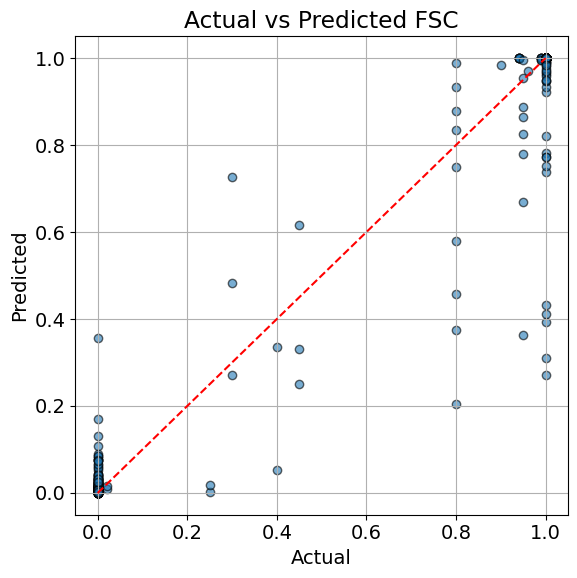

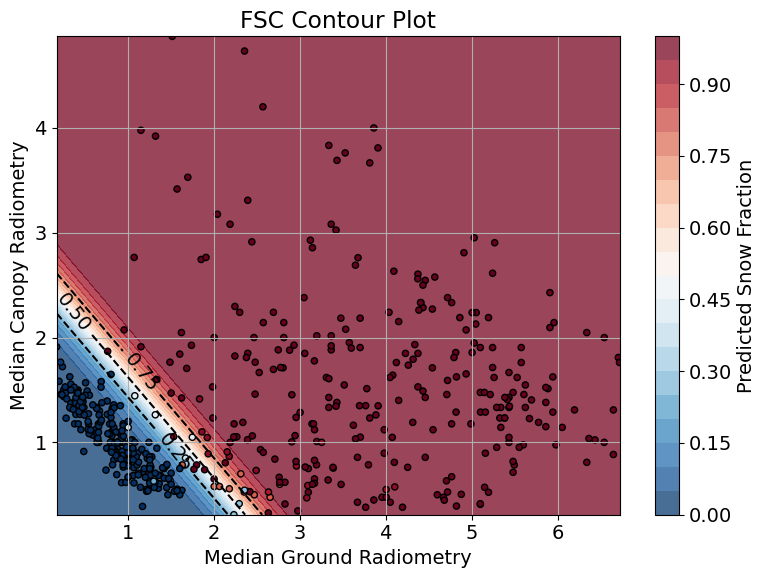

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, confusion_matrix
import statsmodels.api as sm
from scipy.optimize import minimize_scalar

def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

def sharpen_probs(p, alpha):
    p = np.clip(p, 1e-6, 1 - 1e-6)
    return p**alpha / (p**alpha + (1 - p)**alpha)

# --- Preprocessing ---
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "JointSnowBinary", "date"]).copy()
combined = df.copy()

X = combined[["Eg_strong", "Ev_strong"]]
y = combined["JointSnowBinary"]
groups = combined["date"]

family = sm.families.Binomial(link=sm.families.links.Probit())

###
###
###
# Split into binary and fractional
binary_mask = (y == 0) | (y == 1)
frac_mask = ~binary_mask

# Create splits for each subset
gkf = GroupKFold(n_splits=5)
binary_splits = list(gkf.split(X[binary_mask], y[binary_mask], groups=groups[binary_mask]))
frac_splits = list(gkf.split(X[frac_mask], y[frac_mask], groups=groups[frac_mask]))

# Merge splits so that each fold has a balanced mix of binary and fractional
merged_splits = []
for (b_train, b_val), (f_train, f_val) in zip(binary_splits, frac_splits):
    train_idx = X[binary_mask].index[b_train].tolist() + X[frac_mask].index[f_train].tolist()
    val_idx   = X[binary_mask].index[b_val].tolist() + X[frac_mask].index[f_val].tolist()
    merged_splits.append((train_idx, val_idx))
###
###
###

def evaluate_alpha(alpha):
    rmses = []
    for train_idx, val_idx in merged_splits:
        X_tr, X_val = X.loc[train_idx], X.loc[val_idx]
        y_tr, y_val = y.loc[train_idx], y.loc[val_idx]

        X_tr_sm = sm.add_constant(X_tr)
        X_val_sm = sm.add_constant(X_val)

        model = sm.GLM(y_tr, X_tr_sm, family=family)
        result = model.fit()
        y_pred = result.predict(X_val_sm)
        y_pred = sharpen_probs(y_pred, alpha)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)
    return np.mean(rmses)

res = minimize_scalar(evaluate_alpha, bounds=(1, 2), method='bounded')
best_alpha = res.x
print(f"Best alpha: {best_alpha:.4f} with RMSE: {res.fun:.4f}")

# --- Cross-validation with best alpha ---
gkf = GroupKFold(n_splits=5)
rmses = []
rmses_frac = []
biases = []
biases_frac = []
bin_accuracies = []

all_y_val = []
all_y_pred = []
all_Eg_val = []
all_Ev_val = []
all_yval_color = []
all_actual_bins = []
all_pred_bins = []

for train_idx, val_idx in merged_splits:
    X_tr, X_val = X.loc[train_idx], X.loc[val_idx]
    y_tr, y_val = y.loc[train_idx], y.loc[val_idx]

    X_tr_sm = sm.add_constant(X_tr)
    X_val_sm = sm.add_constant(X_val)

    model = sm.GLM(y_tr, X_tr_sm, family=family)
    result = model.fit()
    y_pred = sharpen_probs(result.predict(X_val_sm), best_alpha)

    actual_bins = y_val.apply(fsc_bin)
    pred_bins = pd.Series(y_pred, index=y_val.index).apply(fsc_bin)
    bin_accuracy = (actual_bins == pred_bins).mean()
    bin_accuracies.append(bin_accuracy)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    bias = np.mean(y_pred - y_val)
    rmses.append(rmse)
    biases.append(bias)

    mask_frac = (y_val > 0) & (y_val < 1)
    if mask_frac.sum() > 0:
        frac_rmse = np.sqrt(mean_squared_error(y_val[mask_frac], y_pred[mask_frac]))
        frac_bias = np.mean(y_pred[mask_frac] - y_val[mask_frac])
        rmses_frac.append(frac_rmse)
        biases_frac.append(frac_bias)

    all_y_val.extend(y_val)
    all_y_pred.extend(y_pred)
    all_Eg_val.extend(X_val["Eg_strong"])
    all_Ev_val.extend(X_val["Ev_strong"])
    all_yval_color.extend(y_val)
    all_actual_bins.extend(actual_bins)
    all_pred_bins.extend(pred_bins)

# --- Final model ---
X_sm = sm.add_constant(X)
final_model = sm.GLM(y, X_sm, family=family).fit()

# --- Summary ---
print(f"Cross-Validation RMSE (mean ± std): {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")
print(f"Cross-Validation Bias (mean ± std): {np.mean(biases):.4f} ± {np.std(biases):.4f}")
print(f"Fractional RMSE (mean ± std): {np.mean(rmses_frac):.4f} ± {np.std(rmses_frac):.4f}")
print(f"Fractional Bias (mean ± std): {np.mean(biases_frac):.4f} ± {np.std(biases_frac):.4f}")
print(f"Classification Accuracy (4-bin): {np.mean(bin_accuracies):.2%}")

bin_labels = ["[0,0.05)", "[0.05,0.5)", "[0.5,0.95)", "[0.95,1]"]
conf = confusion_matrix(all_actual_bins, all_pred_bins, labels=bin_labels)
conf_df = pd.DataFrame(conf, index=bin_labels, columns=bin_labels)
print("\nConfusion Matrix (Aggregated across folds):")
print(conf_df)

# --- Plot 1: Actual vs Predicted ---
plt.figure(figsize=(6, 6))
plt.scatter(all_y_val, all_y_pred, alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted FSC")
plt.grid(True)
plt.tight_layout()
plt.savefig('poster_reclassified_actual_predicted.svg')
plt.show()

# --- Plot 2: Contour Plot ---
eg_range = np.linspace(df["Eg_strong"].min(), df["Eg_strong"].max(), 300)
ev_range = np.linspace(df["Ev_strong"].min(), df["Ev_strong"].max(), 300)
Eg_grid, Ev_grid = np.meshgrid(eg_range, ev_range)

grid_df = pd.DataFrame({
    "Eg_strong": Eg_grid.ravel(),
    "Ev_strong": Ev_grid.ravel(),
})
grid_df["const"] = 1
grid_df = grid_df[["const", "Eg_strong", "Ev_strong"]]

Z = final_model.predict(grid_df)
Z = sharpen_probs(Z, best_alpha)
Z = Z.values.reshape(Eg_grid.shape)

plt.figure(figsize=(8, 6))
contour = plt.contourf(Eg_grid, Ev_grid, Z, levels=np.linspace(0, 1, 21), cmap='RdBu_r', alpha=0.75)
cbar = plt.colorbar(contour)
cbar.set_label('Predicted Snow Fraction')

lines = plt.contour(Eg_grid, Ev_grid, Z, levels=[0, 0.25, 0.5, 0.75, 1], colors='k', linestyles='--')
plt.clabel(lines, fmt='%1.2f')

plt.scatter(all_Eg_val, all_Ev_val, c=all_yval_color, cmap='RdBu_r', edgecolor='k', s=20)
plt.xlabel("Median Ground Radiometry")
plt.ylabel("Median Canopy Radiometry")
plt.title("FSC Contour Plot")
plt.grid(True)
plt.tight_layout()
plt.savefig('poster_reclassified_contour.svg')
plt.show()


Best alpha: 1.1289 with RMSE: 0.0890
Cross-Validation RMSE (mean ± std): 0.0890 ± 0.0396
Cross-Validation Bias (mean ± std): -0.0082 ± 0.0097
Fractional RMSE (mean ± std): 0.1953 ± 0.0755
Fractional Bias (mean ± std): -0.0559 ± 0.0715
Classification Accuracy (4-bin): 90.41%

Confusion Matrix (Aggregated across folds):
            [0,0.05)  [0.05,0.5)  [0.5,0.95)  [0.95,1]
[0,0.05)         197          18           0         0
[0.05,0.5)         3           5           2         0
[0.5,0.95)         0           4           6         8
[0.95,1]           1           4          10       264


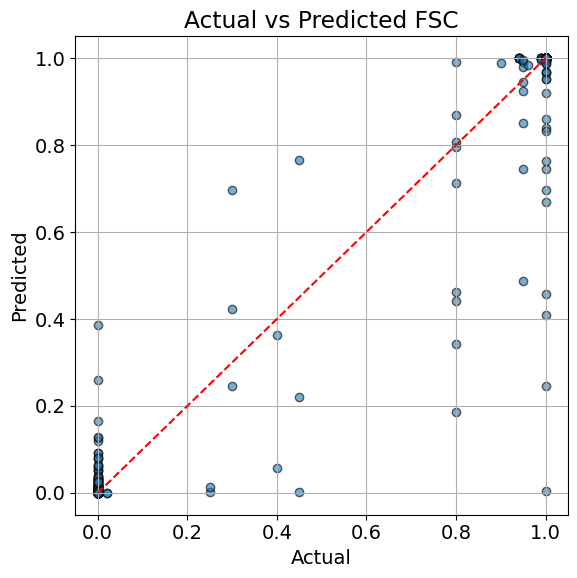

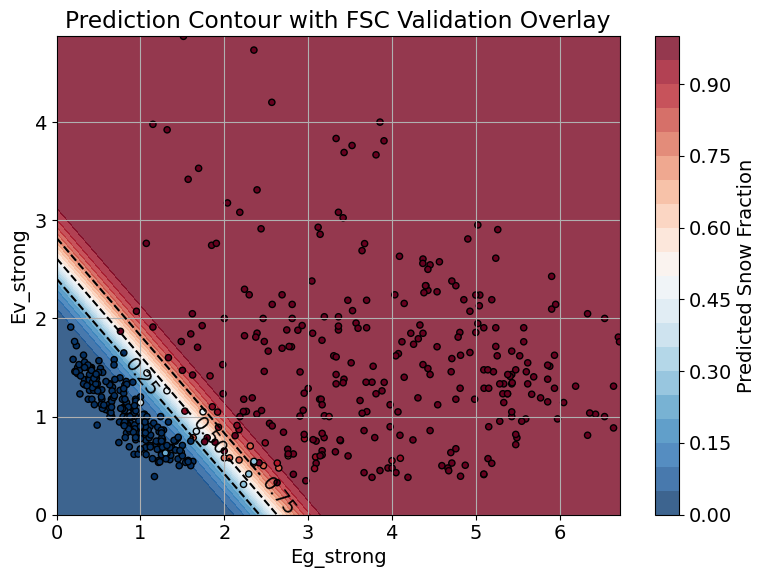

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, confusion_matrix
import statsmodels.api as sm
from scipy.optimize import minimize_scalar

def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

def sharpen_probs(p, alpha):
    p = np.clip(p, 1e-6, 1 - 1e-6)
    return p**alpha / (p**alpha + (1 - p)**alpha)

# --- Preprocessing ---
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "pv", "pg", "pvpg", "JointSnowBinary", "date"]).copy()
combined = df.copy()

X = combined[["Eg_strong", "Ev_strong", "pv", "pg", "pvpg"]]
y = combined["JointSnowBinary"]
groups = combined["date"]

family = sm.families.Binomial(link=sm.families.links.Probit())


###
###
###
# Split into binary and fractional
binary_mask = (y == 0) | (y == 1)
frac_mask = ~binary_mask

# Create splits for each subset
gkf = GroupKFold(n_splits=5)
binary_splits = list(gkf.split(X[binary_mask], y[binary_mask], groups=groups[binary_mask]))
frac_splits = list(gkf.split(X[frac_mask], y[frac_mask], groups=groups[frac_mask]))

# Merge splits so that each fold has a balanced mix of binary and fractional
merged_splits = []
for (b_train, b_val), (f_train, f_val) in zip(binary_splits, frac_splits):
    train_idx = X[binary_mask].index[b_train].tolist() + X[frac_mask].index[f_train].tolist()
    val_idx   = X[binary_mask].index[b_val].tolist() + X[frac_mask].index[f_val].tolist()
    merged_splits.append((train_idx, val_idx))
###
###
###

def evaluate_alpha(alpha):
    rmses = []
    # for train_idx, val_idx in GroupKFold(n_splits=5).split(X, y, groups=groups):
    for train_idx, val_idx in merged_splits:
        X_tr, X_val = X.loc[train_idx], X.loc[val_idx]
        y_tr, y_val = y.loc[train_idx], y.loc[val_idx]

        X_tr_sm = sm.add_constant(X_tr)
        X_val_sm = sm.add_constant(X_val)

        model = sm.GLM(y_tr, X_tr_sm, family=family)
        result = model.fit()
        y_pred = result.predict(X_val_sm)
        y_pred = sharpen_probs(y_pred, alpha)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)
    return np.mean(rmses)

res = minimize_scalar(evaluate_alpha, bounds=(1, 2), method='bounded')
best_alpha = res.x
print(f"Best alpha: {best_alpha:.4f} with RMSE: {res.fun:.4f}")

# --- Cross-validation with best alpha ---
gkf = GroupKFold(n_splits=5)
rmses = []
rmses_frac = []
biases = []
biases_frac = []
bin_accuracies = []

all_y_val = []
all_y_pred = []
all_Eg_val = []
all_Ev_val = []
all_pg_val = []
all_pv_val = []
all_yval_color = []
all_actual_bins = []
all_pred_bins = []

# for train_idx, val_idx in gkf.split(X, y, groups=groups):
for train_idx, val_idx in merged_splits:
    X_tr, X_val = X.loc[train_idx], X.loc[val_idx]
    y_tr, y_val = y.loc[train_idx], y.loc[val_idx]

    X_tr_sm = sm.add_constant(X_tr)
    X_val_sm = sm.add_constant(X_val)

    model = sm.GLM(y_tr, X_tr_sm, family=family)
    result = model.fit()
    y_pred = sharpen_probs(result.predict(X_val_sm), best_alpha)

    actual_bins = y_val.apply(fsc_bin)
    pred_bins = pd.Series(y_pred, index=y_val.index).apply(fsc_bin)
    bin_accuracy = (actual_bins == pred_bins).mean()
    bin_accuracies.append(bin_accuracy)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    bias = np.mean(y_pred - y_val)
    rmses.append(rmse)
    biases.append(bias)

    mask_frac = (y_val > 0) & (y_val < 1)
    if mask_frac.sum() > 0:
        frac_rmse = np.sqrt(mean_squared_error(y_val[mask_frac], y_pred[mask_frac]))
        frac_bias = np.mean(y_pred[mask_frac] - y_val[mask_frac])
        rmses_frac.append(frac_rmse)
        biases_frac.append(frac_bias)

    all_y_val.extend(y_val)
    all_y_pred.extend(y_pred)
    all_Eg_val.extend(X_val["Eg_strong"])
    all_Ev_val.extend(X_val["Ev_strong"])
    all_pg_val.extend(X_val["pg"])
    all_pv_val.extend(X_val["pv"])
    all_yval_color.extend(y_val)
    all_actual_bins.extend(actual_bins)
    all_pred_bins.extend(pred_bins)

# --- Final model ---
X_sm = sm.add_constant(X)
final_model = sm.GLM(y, X_sm, family=family).fit()

# --- Summary ---
print(f"Cross-Validation RMSE (mean ± std): {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")
print(f"Cross-Validation Bias (mean ± std): {np.mean(biases):.4f} ± {np.std(biases):.4f}")
print(f"Fractional RMSE (mean ± std): {np.mean(rmses_frac):.4f} ± {np.std(rmses_frac):.4f}")
print(f"Fractional Bias (mean ± std): {np.mean(biases_frac):.4f} ± {np.std(biases_frac):.4f}")
print(f"Classification Accuracy (4-bin): {np.mean(bin_accuracies):.2%}")

bin_labels = ["[0,0.05)", "[0.05,0.5)", "[0.5,0.95)", "[0.95,1]"]
conf = confusion_matrix(all_actual_bins, all_pred_bins, labels=bin_labels)
conf_df = pd.DataFrame(conf, index=bin_labels, columns=bin_labels)
print("\nConfusion Matrix (Aggregated across folds):")
print(conf_df)

# --- Plot 1: Actual vs Predicted ---
plt.figure(figsize=(6, 6))
plt.scatter(all_y_val, all_y_pred, alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted FSC")
plt.grid(True)
plt.tight_layout()
# plt.savefig("poster_fraction_probit_actual_predicted_5fold.svg")
plt.show()

import statsmodels.api as sm
# --- Prediction Grid ---
eg_vals = np.linspace(0, X["Eg_strong"].max(), 300)
ev_vals = np.linspace(0, X["Ev_strong"].max(), 300)
pg_vals = np.linspace(X["pg"].min(), X["pg"].max(), 300)
pv_vals = np.linspace(X["pv"].min(), X["pv"].max(), 300)
EG, EV = np.meshgrid(eg_vals, ev_vals)

Eg_fixed = X["Eg_strong"].median()
Ev_fixed = X["Ev_strong"].median()
pv_fixed = X["pv"].median()
pg_fixed = X["pg"].median()
pvpg_fixed = X["pvpg"].median()

grid_df = pd.DataFrame({
    "const": 1,
    "Eg_strong": EG.ravel(),
    "Ev_strong": EV.ravel(),
    "pv": pv_fixed,
    "pg": pg_fixed,
    "pvpg": pvpg_fixed
})
# grid_df = pd.DataFrame({
#     "const": 1,
#     "Eg_strong": Eg_fixed,
#     "Ev_strong": Ev_fixed,
#     "pv": EV.ravel(),
#     "pg": EG.ravel(),
#     "pvpg": pvpg_fixed
# })
grid_df = sm.add_constant(grid_df)
Z = final_model.predict(grid_df)
Z = sharpen_probs(Z, best_alpha)
Z = Z.to_numpy().reshape(EG.shape)

# --- Plotting ---
plt.figure(figsize=(8, 6))
contour = plt.contourf(EG, EV, Z, levels=np.linspace(0, 1, 21), cmap='RdBu_r', alpha=0.8)
cbar = plt.colorbar(contour)
cbar.set_label('Predicted Snow Fraction')

# Contour lines at key thresholds
lines = plt.contour(EG, EV, Z, levels=[0, 0.25, 0.5, 0.75, 1], colors='k', linestyles='--')
plt.clabel(lines, fmt='%1.2f')

# Scatter actual validation points colored by true snow fraction
plt.scatter(all_Eg_val, all_Ev_val, c=all_yval_color, cmap='RdBu_r', edgecolor='k', s=20)

plt.xlabel("Eg_strong")
plt.ylabel("Ev_strong")
plt.title("Prediction Contour with FSC Validation Overlay")
plt.grid(True)
plt.tight_layout()
# plt.savefig("poster_fraction_probit_contour_plot_5fold.svg")
plt.show()


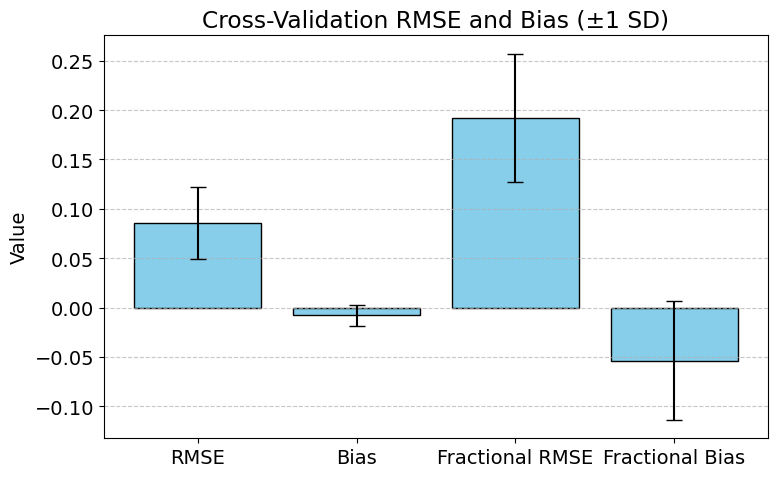

In [8]:
import matplotlib.pyplot as plt

# Data to plot
metrics = [
    "RMSE",
    "Bias",
    "Fractional RMSE",
    "Fractional Bias"
]

means = [
    np.mean(rmses),
    np.mean(biases),
    np.mean(rmses_frac),
    np.mean(biases_frac)
]

stds = [
    np.std(rmses),
    np.std(biases),
    np.std(rmses_frac),
    np.std(biases_frac)
]

# Plotting
plt.figure(figsize=(8, 5))
x = np.arange(len(metrics))
plt.bar(x, means, yerr=stds, capsize=6, color='skyblue', edgecolor='black')
plt.xticks(x, metrics)
plt.ylabel("Value")
plt.title("Cross-Validation RMSE and Bias (±1 SD)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig("poster_reclassified_probit_cv_metrics_5fold.svg")
plt.show()


Test Set RMSE: 0.1137
Test Set Bias: 0.0218
Test Set Fractional RMSE: 0.0272
Test Set Fractional Bias: -0.0008
Test Set Classification Accuracy (4-bin): 95.15%

Test Set Confusion Matrix (4-bin):
            [0,0.05)  [0.05,0.5)  [0.5,0.95)  [0.95,1]
[0,0.05)          57           3           2         0
[0.05,0.5)         0           0           0         0
[0.5,0.95)         0           0           0         0
[0.95,1]           0           0           0        41


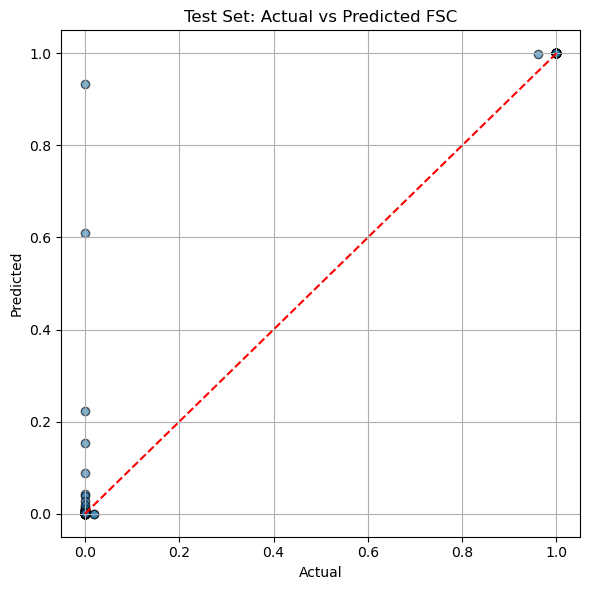

In [5]:
# --- Test Set Evaluation Script ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, confusion_matrix

# --- Prepare Test Data ---
X_test = test[["Eg_strong", "Ev_strong", "pv", "pg", "pvpg"]]
y_test = test["JointSnowBinary"]

X_test_sm = sm.add_constant(X_test)
y_test_pred = final_model.predict(X_test_sm)
y_test_pred_sharp = sharpen_probs(y_test_pred, best_alpha)

# --- Compute Metrics ---
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_sharp))
test_bias = np.mean(y_test_pred_sharp - y_test)

mask_frac = (y_test > 0) & (y_test < 1)
if mask_frac.sum() > 0:
    test_rmse_frac = np.sqrt(mean_squared_error(y_test[mask_frac], y_test_pred_sharp[mask_frac]))
    test_bias_frac = np.mean(y_test_pred_sharp[mask_frac] - y_test[mask_frac])
else:
    test_rmse_frac = np.nan
    test_bias_frac = np.nan

bin_labels = ["[0,0.05)", "[0.05,0.5)", "[0.5,0.95)", "[0.95,1]"]
test_actual_bins = y_test.apply(fsc_bin)
test_pred_bins = pd.Series(y_test_pred_sharp, index=y_test.index).apply(fsc_bin)
test_bin_accuracy = (test_actual_bins == test_pred_bins).mean()

conf_test = confusion_matrix(test_actual_bins, test_pred_bins, labels=bin_labels)
conf_test_df = pd.DataFrame(conf_test, index=bin_labels, columns=bin_labels)

# --- Print Result Summary ---
print(f"Test Set RMSE: {test_rmse:.4f}")
print(f"Test Set Bias: {test_bias:.4f}")
print(f"Test Set Fractional RMSE: {test_rmse_frac:.4f}")
print(f"Test Set Fractional Bias: {test_bias_frac:.4f}")
print(f"Test Set Classification Accuracy (4-bin): {test_bin_accuracy:.2%}")
print("\nTest Set Confusion Matrix (4-bin):")
print(conf_test_df)

# --- Plot: Actual vs Predicted ---
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred_sharp, alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Test Set: Actual vs Predicted FSC")
plt.grid(True)
plt.tight_layout()
plt.show()


/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0



Final model a: 0.8368, b: 1.7270
Final beta: {'const': -2.563748028110859, 'Eg_strong': 1.6778429899605447, 'Ev_strong': 1.2627092423317379, 'pv': 0.6480709303030983, 'pg': -0.08885919511094217, 'pvpg': -1.1258658739412382}

Cross-Validation RMSE (mean ± std): 0.1171 ± 0.0478
Cross-Validation Bias (mean ± std): 0.0064 ± 0.0187
Fractional RMSE (mean ± std): 0.3151 ± 0.1425
Fractional Bias (mean ± std): 0.0343 ± 0.1956
Classification Accuracy (4-bin): 94.83%

Confusion Matrix (Aggregated across folds):
            [0,0.05)  [0.05,0.5)  [0.5,0.95)  [0.95,1]
[0,0.05)         212           0           1         2
[0.05,0.5)         2           2           0         6
[0.5,0.95)         2           2           3        11
[0.95,1]           0           1           0       278


/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


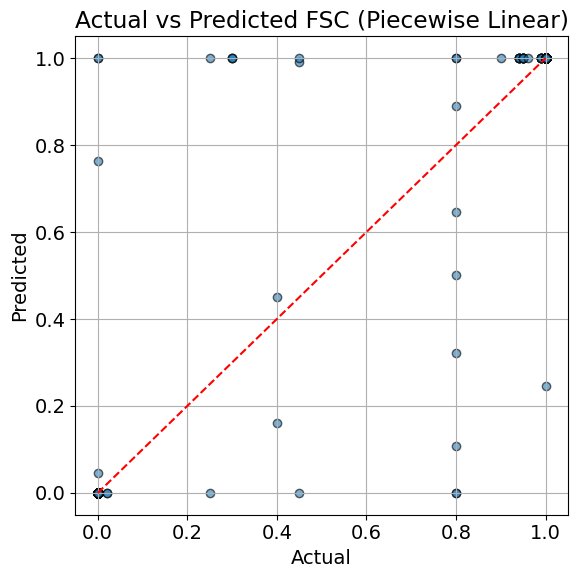

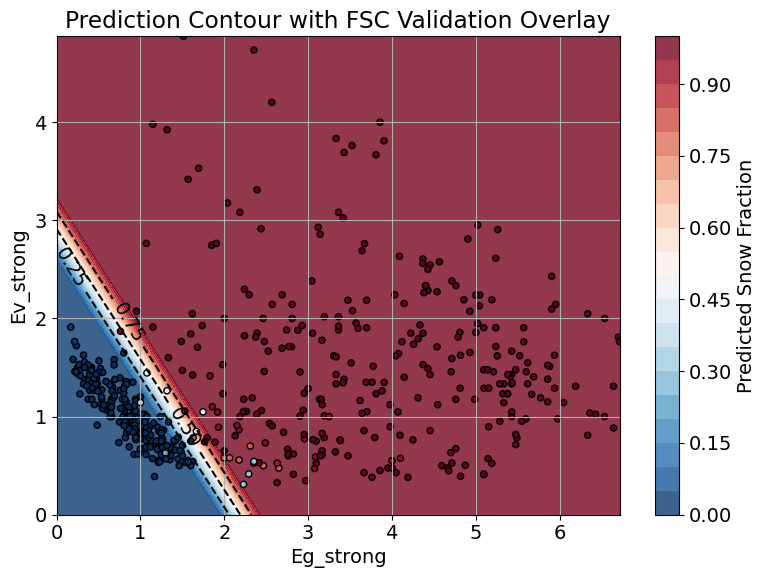

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, confusion_matrix
from scipy.optimize import minimize

# --- Piecewise linear mapping ---
def piecewise_map(z, a, b):
    z = np.asarray(z)
    result = np.zeros_like(z)
    result[z >= b] = 1
    mask = (z > a) & (z < b)
    result[mask] = (z[mask] - a) / (b - a)
    return result

def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

# --- Preprocessing ---
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "pv", "pg", "pvpg", "JointSnowBinary", "date"]).copy()
combined = df.copy()

X_raw = combined[["Eg_strong", "Ev_strong", "pv", "pg", "pvpg"]].copy()
X = X_raw.copy()
X.insert(0, "const", 1)
y = combined["JointSnowBinary"]
groups = combined["date"]
X_cols = X.columns

# --- Stratified GroupKFold on binary vs fractional data ---
binary_mask = (y == 0) | (y == 1)
frac_mask = ~binary_mask
gkf = GroupKFold(n_splits=5)

binary_splits = list(gkf.split(X[binary_mask], y[binary_mask], groups=groups[binary_mask]))
frac_splits = list(gkf.split(X[frac_mask], y[frac_mask], groups=groups[frac_mask]))

merged_splits = []
for (b_tr, b_val), (f_tr, f_val) in zip(binary_splits, frac_splits):
    train_idx = X[binary_mask].index[b_tr].tolist() + X[frac_mask].index[f_tr].tolist()
    val_idx = X[binary_mask].index[b_val].tolist() + X[frac_mask].index[f_val].tolist()
    merged_splits.append((train_idx, val_idx))

# --- Cross-validation ---
rmses, rmses_frac, biases, biases_frac, bin_accuracies = [], [], [], [], []
all_y_val, all_y_pred = [], []
all_Eg_val, all_Ev_val, all_yval_color = [], [], []
all_actual_bins, all_pred_bins = [], []

for train_idx, val_idx in merged_splits:
    X_tr = X.loc[train_idx].values
    y_tr = y.loc[train_idx].values
    X_val = X.loc[val_idx].values
    y_val = y.loc[val_idx]

    def objective(params):
        a, b = params[-2], params[-1]
        if b <= a:
            return np.inf
        beta = params[:-2]
        z = X_tr @ beta
        y_pred = piecewise_map(z, a, b)
        return np.sqrt(mean_squared_error(y_tr, y_pred))

    init_params = np.zeros(X_tr.shape[1] + 2)
    init_params[-2] = -1
    init_params[-1] = 1
    res = minimize(objective, init_params, method='L-BFGS-B')
    params = res.x
    beta, a, b = params[:-2], params[-2], params[-1]

    z_val = X_val @ beta
    y_pred = piecewise_map(z_val, a, b)

    actual_bins = y_val.apply(fsc_bin)
    pred_bins = pd.Series(y_pred, index=y_val.index).apply(fsc_bin)
    bin_accuracy = (actual_bins == pred_bins).mean()
    bin_accuracies.append(bin_accuracy)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    bias = np.mean(y_pred - y_val)
    rmses.append(rmse)
    biases.append(bias)

    mask_frac = (y_val > 0) & (y_val < 1)
    if mask_frac.sum() > 0:
        frac_rmse = np.sqrt(mean_squared_error(y_val[mask_frac], y_pred[mask_frac]))
        frac_bias = np.mean(y_pred[mask_frac] - y_val[mask_frac])
        rmses_frac.append(frac_rmse)
        biases_frac.append(frac_bias)

    all_y_val.extend(y_val)
    all_y_pred.extend(y_pred)
    all_Eg_val.extend(X_raw.loc[val_idx, "Eg_strong"])
    all_Ev_val.extend(X_raw.loc[val_idx, "Ev_strong"])
    all_yval_color.extend(y_val)
    all_actual_bins.extend(actual_bins)
    all_pred_bins.extend(pred_bins)

# --- Final model on all data ---
X_all = X.values
y_all = y.values

def final_objective(params):
    a, b = params[-2], params[-1]
    if b <= a:
        return np.inf
    beta = params[:-2]
    z = X_all @ beta
    y_pred = piecewise_map(z, a, b)
    return np.sqrt(mean_squared_error(y_all, y_pred))

init_params = np.zeros(X_all.shape[1] + 2)
init_params[-2] = -1
init_params[-1] = 1
res_final = minimize(final_objective, init_params, method='L-BFGS-B')
params_final = res_final.x
beta_final, a_final, b_final = params_final[:-2], params_final[-2], params_final[-1]
print(f"\nFinal model a: {a_final:.4f}, b: {b_final:.4f}")
print("Final beta:", dict(zip(X_cols, beta_final)))


# --- Summary ---
print(f"\nCross-Validation RMSE (mean ± std): {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")
print(f"Cross-Validation Bias (mean ± std): {np.mean(biases):.4f} ± {np.std(biases):.4f}")
print(f"Fractional RMSE (mean ± std): {np.mean(rmses_frac):.4f} ± {np.std(rmses_frac):.4f}")
print(f"Fractional Bias (mean ± std): {np.mean(biases_frac):.4f} ± {np.std(biases_frac):.4f}")
print(f"Classification Accuracy (4-bin): {np.mean(bin_accuracies):.2%}")

bin_labels = ["[0,0.05)", "[0.05,0.5)", "[0.5,0.95)", "[0.95,1]"]
conf = confusion_matrix(all_actual_bins, all_pred_bins, labels=bin_labels)
conf_df = pd.DataFrame(conf, index=bin_labels, columns=bin_labels)
print("\nConfusion Matrix (Aggregated across folds):")
print(conf_df)

# --- Plot 1: Actual vs Predicted ---
plt.figure(figsize=(6, 6))
plt.scatter(all_y_val, all_y_pred, alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted FSC (Piecewise Linear)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Prediction Grid ---
eg_vals = np.linspace(0, X_raw["Eg_strong"].max(), 300)
ev_vals = np.linspace(0, X_raw["Ev_strong"].max(), 300)
EG, EV = np.meshgrid(eg_vals, ev_vals)

pv_fixed = X_raw["pv"].median()
pg_fixed = X_raw["pg"].median()
pvpg_fixed = X_raw["pvpg"].median()

grid_df = pd.DataFrame({
    "const": 1,
    "Eg_strong": EG.ravel(),
    "Ev_strong": EV.ravel(),
    "pv": pv_fixed,
    "pg": pg_fixed,
    "pvpg": pvpg_fixed
})
z_grid = grid_df.values @ beta_final
Z = piecewise_map(z_grid, a_final, b_final).reshape(EG.shape)

# --- Contour Plot ---
plt.figure(figsize=(8, 6))
contour = plt.contourf(EG, EV, Z, levels=np.linspace(0, 1, 21), cmap='RdBu_r', alpha=0.8)
cbar = plt.colorbar(contour)
cbar.set_label('Predicted Snow Fraction')

lines = plt.contour(EG, EV, Z, levels=[0.25, 0.5, 0.75], colors='k', linestyles='--')
plt.clabel(lines, fmt='%1.2f')

plt.scatter(all_Eg_val, all_Ev_val, c=all_yval_color, cmap='RdBu_r', edgecolor='k', s=20)
plt.xlabel("Eg_strong")
plt.ylabel("Ev_strong")
plt.title("Prediction Contour with FSC Validation Overlay")
plt.grid(True)
plt.tight_layout()
plt.show()


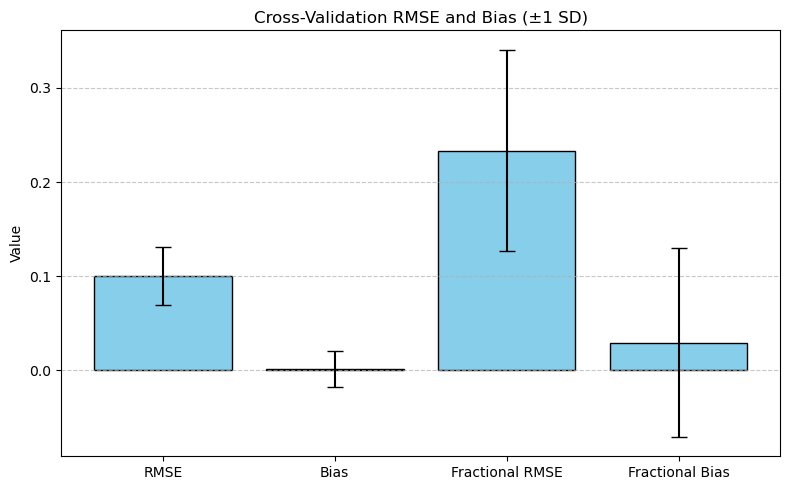

In [25]:
import matplotlib.pyplot as plt

# Data to plot
metrics = [
    "RMSE",
    "Bias",
    "Fractional RMSE",
    "Fractional Bias"
]

means = [
    np.mean(rmses),
    np.mean(biases),
    np.mean(rmses_frac),
    np.mean(biases_frac)
]

stds = [
    np.std(rmses),
    np.std(biases),
    np.std(rmses_frac),
    np.std(biases_frac)
]

# Plotting
plt.figure(figsize=(8, 5))
x = np.arange(len(metrics))
plt.bar(x, means, yerr=stds, capsize=6, color='skyblue', edgecolor='black')
plt.xticks(x, metrics)
plt.ylabel("Value")
plt.title("Cross-Validation RMSE and Bias (±1 SD)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig("poster_fraction_probit_cv_metrics_more.svg")
plt.show()



Top SVR Hyperparameter Combinations (by mean RMSE):
C=100, epsilon=0.05, gamma=scale, RMSE=0.1301 ± 0.0523, Fractional RMSE=0.2786 ± 0.1069, Bin Acc=70.17%
C=10, epsilon=0.1, gamma=scale, RMSE=0.1322 ± 0.0422, Fractional RMSE=0.2652 ± 0.0879, Bin Acc=61.11%
C=100, epsilon=0.01, gamma=scale, RMSE=0.1353 ± 0.0524, Fractional RMSE=0.3001 ± 0.1205, Bin Acc=73.52%

Best parameters used for plotting: C=100, epsilon=0.05, gamma=scale


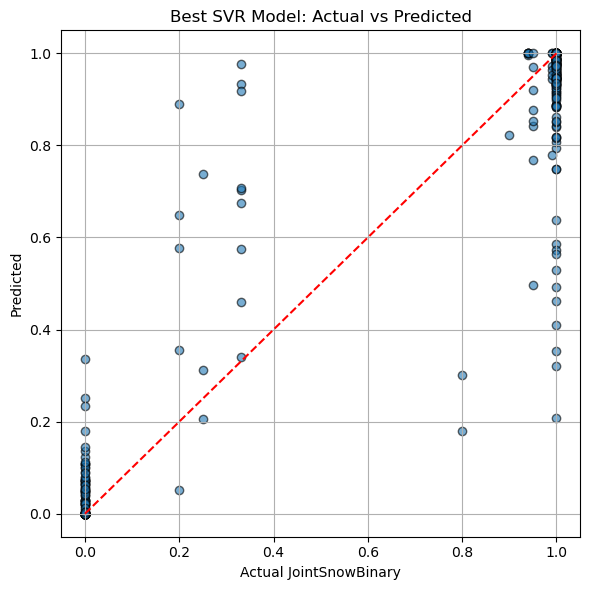

In [3]:
from sklearn.svm import SVR
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import product

def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

# Preprocessing
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "pv", "pg", "pvpg", "JointSnowBinary", "date"]).copy()
extremes = df[(df["JointSnowBinary"] == 0) | (df["JointSnowBinary"] == 1)]
midrange = df[(df["JointSnowBinary"] > 0) & (df["JointSnowBinary"] < 1)]
combined = pd.concat([extremes, midrange])

cameras = combined['date'].unique()
np.random.seed(1)
np.random.shuffle(cameras)
n_test = int(round(len(cameras) * 0.2))
test_cameras = cameras[:n_test]
train_cameras = cameras[n_test:]

train = combined[combined['date'].isin(train_cameras)].copy()
test = combined[combined['date'].isin(test_cameras)].copy()

X_train = train[["Eg_strong", "Ev_strong", "pv", "pg", "pvpg"]]
y_train = train["JointSnowBinary"]
groups = train["date"]

# Grid setup
param_grid = {
    "C": [1, 10, 100],
    "epsilon": [0.01, 0.05, 0.1],
    "gamma": ["scale", "auto"],
}
param_combinations = list(product(param_grid["C"], param_grid["epsilon"], param_grid["gamma"]))

gkf = GroupKFold(n_splits=4)
results = []
best_model = None
best_rmse = np.inf

for C, epsilon, gamma in param_combinations:
    rmses = []
    rmses_frac = []
    bin_accuracies = []

    all_y_val = []
    all_y_pred = []
    all_Eg_val = []
    all_Ev_val = []
    all_yval_color = []
    all_actual_bins = []
    all_pred_bins = []

    for train_idx, val_idx in gkf.split(X_train, y_train, groups=groups):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = SVR(kernel="rbf", C=C, epsilon=epsilon, gamma=gamma)
        model.fit(X_tr, y_tr)
        y_pred = np.clip(model.predict(X_val), 0, 1)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)

        mask_frac = (y_val > 0) & (y_val < 1)
        if mask_frac.sum() > 0:
            rmse_frac = np.sqrt(mean_squared_error(y_val[mask_frac], y_pred[mask_frac]))
            rmses_frac.append(rmse_frac)

        actual_bins = y_val.apply(fsc_bin)
        pred_bins = pd.Series(y_pred, index=y_val.index).apply(fsc_bin)
        bin_accuracy = (actual_bins == pred_bins).mean()
        bin_accuracies.append(bin_accuracy)

        all_y_val.extend(y_val)
        all_y_pred.extend(y_pred)
        all_Eg_val.extend(X_val["Eg_strong"])
        all_Ev_val.extend(X_val["Ev_strong"])
        all_yval_color.extend(y_val)
        all_actual_bins.extend(actual_bins)
        all_pred_bins.extend(pred_bins)

    mean_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    mean_frac_rmse = np.mean(rmses_frac) if rmses_frac else np.nan
    std_frac_rmse = np.std(rmses_frac) if rmses_frac else np.nan
    mean_bin_acc = np.mean(bin_accuracies)

    results.append({
        "C": C,
        "epsilon": epsilon,
        "gamma": gamma,
        "mean_rmse": mean_rmse,
        "std_rmse": std_rmse,
        "mean_frac_rmse": mean_frac_rmse,
        "std_frac_rmse": std_frac_rmse,
        "bin_accuracy": mean_bin_acc
    })

    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_model = SVR(kernel="rbf", C=C, epsilon=epsilon, gamma=gamma)
        best_model.fit(X_train, y_train)
        best_y_val = all_y_val
        best_y_pred = all_y_pred
        best_Eg_val = all_Eg_val
        best_Ev_val = all_Ev_val
        best_yval_color = all_yval_color
        best_actual_bins = all_actual_bins
        best_pred_bins = all_pred_bins
        best_params = (C, epsilon, gamma)

# Sort and display top 3
results = sorted(results, key=lambda x: x["mean_rmse"])
print("\nTop SVR Hyperparameter Combinations (by mean RMSE):")
for r in results[:3]:
    print(f"C={r['C']}, epsilon={r['epsilon']}, gamma={r['gamma']}, "
          f"RMSE={r['mean_rmse']:.4f} ± {r['std_rmse']:.4f}, "
          f"Fractional RMSE={r['mean_frac_rmse']:.4f} ± {r['std_frac_rmse']:.4f}, "
          f"Bin Acc={r['bin_accuracy']:.2%}")

print(f"\nBest parameters used for plotting: C={best_params[0]}, epsilon={best_params[1]}, gamma={best_params[2]}")

# === PLOTS ===

# 1. Scatter: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(best_y_val, best_y_pred, alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual JointSnowBinary")
plt.ylabel("Predicted")
plt.title("Best SVR Model: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Contour: Prediction surface
# eg_range = np.linspace(df["Eg_strong"].min(), df["Eg_strong"].max(), 300)
# ev_range = np.linspace(df["Ev_strong"].min(), df["Ev_strong"].max(), 300)
# Eg_grid, Ev_grid = np.meshgrid(eg_range, ev_range)
# grid_points = np.column_stack([Eg_grid.ravel(), Ev_grid.ravel()])
# Z = np.clip(best_model.predict(grid_points), 0, 1).reshape(Eg_grid.shape)

# plt.figure(figsize=(8, 6))
# contour = plt.contourf(Eg_grid, Ev_grid, Z, levels=np.linspace(0, 1, 21), cmap='RdBu_r', alpha=0.75)
# cbar = plt.colorbar(contour)
# cbar.set_label('Predicted Snow Fraction')

# lines = plt.contour(Eg_grid, Ev_grid, Z, levels=[0, 0.25, 0.5, 0.75, 1], colors='k', linestyles='--')
# plt.clabel(lines, fmt='%1.2f')

# plt.scatter(best_Eg_val, best_Ev_val, c=best_yval_color, cmap='RdBu_r', edgecolor='k', s=20)
# plt.xlabel("Eg_strong")
# plt.ylabel("Ev_strong")
# plt.title("Best SVR Model: Contour Prediction")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Optional: Confusion Matrix
# from sklearn.metrics import confusion_matrix

# bin_labels = ["[0,0.05)", "[0.05,0.5)", "[0.5,0.95)", "[0.95,1]"]
# conf = confusion_matrix(best_actual_bins, best_pred_bins, labels=bin_labels)
# conf_df = pd.DataFrame(conf, index=bin_labels, columns=bin_labels)

# print("\nConfusion Matrix (Best Model):")
# print(conf_df)


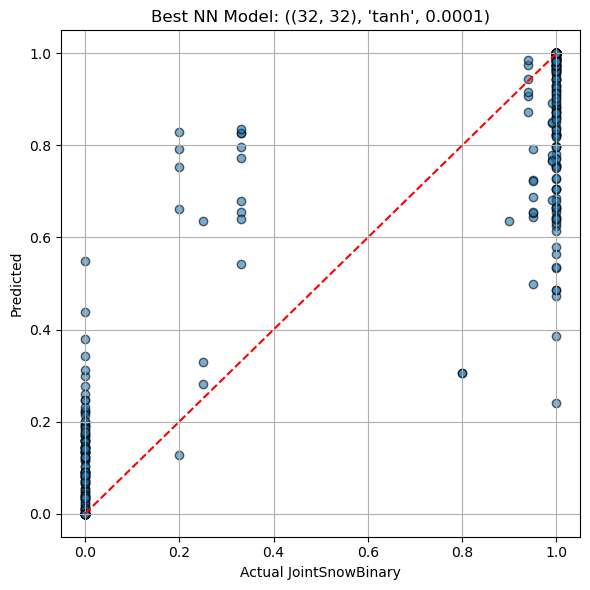


Best Params: hidden_layer_sizes=(32, 32), activation=tanh, alpha=0.0001
Cross-Validation RMSE: 0.1717

Confusion Matrix (Aggregated across folds):
            [0,0.05)  [0.05,0.5)  [0.5,0.95)  [0.95,1]
[0,0.05)          75          77           1         0
[0.05,0.5)         0           3          14         0
[0.5,0.95)         0           2           7         2
[0.95,1]           0           6          85       147


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix
from itertools import product

def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

# Drop missing
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "pv", "pg", "pvpg", "JointSnowBinary", "date"]).copy()
extremes = df[(df["JointSnowBinary"] == 0) | (df["JointSnowBinary"] == 1)]
midrange = df[(df["JointSnowBinary"] > 0) & (df["JointSnowBinary"] < 1)]
combined = pd.concat([extremes, midrange])

cameras = combined['date'].unique()
np.random.seed(1)
np.random.shuffle(cameras)
n_test = int(round(len(cameras) * 0.2))
test_cameras = cameras[:n_test]
train_cameras = cameras[n_test:]

train = combined[combined['date'].isin(train_cameras)].copy()
test = combined[combined['date'].isin(test_cameras)].copy()

X_train = train[["Eg_strong", "Ev_strong", "pv", "pg", "pvpg"]]
y_train = train["JointSnowBinary"]
groups = train["date"]

# Define parameter grid
param_grid = list(product(
    [(16,), (32,), (32, 32)],
    ['relu', 'tanh'],
    [1e-4, 1e-3]
))

gkf = GroupKFold(n_splits=4, shuffle=False)
results = []
best_model = None
best_rmse = np.inf

for hidden_layer_sizes, activation, alpha in param_grid:
    rmses = []
    rmses_fractional = []
    biases = []
    biases_fractional = []
    bin_accuracies = []

    all_y_val = []
    all_y_pred = []
    all_Eg_val = []
    all_Ev_val = []
    all_yval_color = []
    all_actual_bins = []
    all_pred_bins = []

    for train_idx, val_idx in gkf.split(X_train, y_train, groups=groups):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = MLPRegressor(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            solver='adam',
            alpha=alpha,
            max_iter=1000,
            random_state=42
        )
        model.fit(X_tr, y_tr)
        y_pred = np.clip(model.predict(X_val), 0, 1)

        actual_bins = y_val.apply(fsc_bin)
        pred_bins = pd.Series(y_pred, index=y_val.index).apply(fsc_bin)
        bin_accuracy = (actual_bins == pred_bins).mean()
        bin_accuracies.append(bin_accuracy)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        bias = np.mean(y_pred - y_val)
        rmses.append(rmse)
        biases.append(bias)

        mask_frac = (y_val > 0) & (y_val < 1)
        if mask_frac.sum() > 0:
            frac_rmse = np.sqrt(mean_squared_error(y_val[mask_frac], y_pred[mask_frac]))
            frac_bias = np.mean(y_pred[mask_frac] - y_val[mask_frac])
            rmses_fractional.append(frac_rmse)
            biases_fractional.append(frac_bias)

        all_y_val.extend(y_val)
        all_y_pred.extend(y_pred)
        all_Eg_val.extend(X_val["Eg_strong"])
        all_Ev_val.extend(X_val["Ev_strong"])
        all_yval_color.extend(y_val)
        all_actual_bins.extend(actual_bins)
        all_pred_bins.extend(pred_bins)

    mean_rmse = np.mean(rmses)

    results.append({
        "hidden_layer_sizes": hidden_layer_sizes,
        "activation": activation,
        "alpha": alpha,
        "rmse": mean_rmse,
        "rmse_frac": np.mean(rmses_fractional) if rmses_fractional else np.nan,
        "bias": np.mean(biases),
        "bias_frac": np.mean(biases_fractional) if biases_fractional else np.nan,
        "bin_accuracy": np.mean(bin_accuracies)
    })

    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_model = MLPRegressor(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            solver='adam',
            alpha=alpha,
            max_iter=1000,
            random_state=42
        )
        best_model.fit(X_train, y_train)
        best_y_val = all_y_val
        best_y_pred = all_y_pred
        best_Eg_val = all_Eg_val
        best_Ev_val = all_Ev_val
        best_yval_color = all_yval_color
        best_actual_bins = all_actual_bins
        best_pred_bins = all_pred_bins
        best_params = (hidden_layer_sizes, activation, alpha)

# === Final Fit and Plotting ===

# Plot 1: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(best_y_val, best_y_pred, alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual JointSnowBinary")
plt.ylabel("Predicted")
plt.title(f"Best NN Model: {best_params}")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Contour using best model
# eg_range = np.linspace(df["Eg_strong"].min(), df["Eg_strong"].max(), 300)
# ev_range = np.linspace(df["Ev_strong"].min(), df["Ev_strong"].max(), 300)
# Eg_grid, Ev_grid = np.meshgrid(eg_range, ev_range)

# grid_points = pd.DataFrame({
#     "Eg_strong": Eg_grid.ravel(),
#     "Ev_strong": Ev_grid.ravel()
# })
# Z = np.clip(best_model.predict(grid_points), 0, 1).reshape(Eg_grid.shape)

# plt.figure(figsize=(8, 6))
# contour = plt.contourf(Eg_grid, Ev_grid, Z, levels=np.linspace(0, 1, 21), cmap='RdBu_r', alpha=0.75)
# cbar = plt.colorbar(contour)
# cbar.set_label('Predicted Snow Fraction')

# lines = plt.contour(Eg_grid, Ev_grid, Z, levels=[0, 0.25, 0.5, 0.75, 1], colors='k', linestyles='--')
# plt.clabel(lines, fmt='%1.2f')
# plt.scatter(best_Eg_val, best_Ev_val, c=best_yval_color, cmap='RdBu_r', edgecolor='k', s=20)
# plt.xlabel("Eg_strong")
# plt.ylabel("Ev_strong")
# plt.title("Best NN Model: Contour Prediction")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# Summary
print(f"\nBest Params: hidden_layer_sizes={best_params[0]}, activation={best_params[1]}, alpha={best_params[2]}")
print(f"Cross-Validation RMSE: {best_rmse:.4f}")

bin_labels = ["[0,0.05)", "[0.05,0.5)", "[0.5,0.95)", "[0.95,1]"]
conf = confusion_matrix(best_actual_bins, best_pred_bins, labels=bin_labels)
conf_df = pd.DataFrame(conf, index=bin_labels, columns=bin_labels)

print("\nConfusion Matrix (Aggregated across folds):")
print(conf_df)


### Train on fraction, result on all data

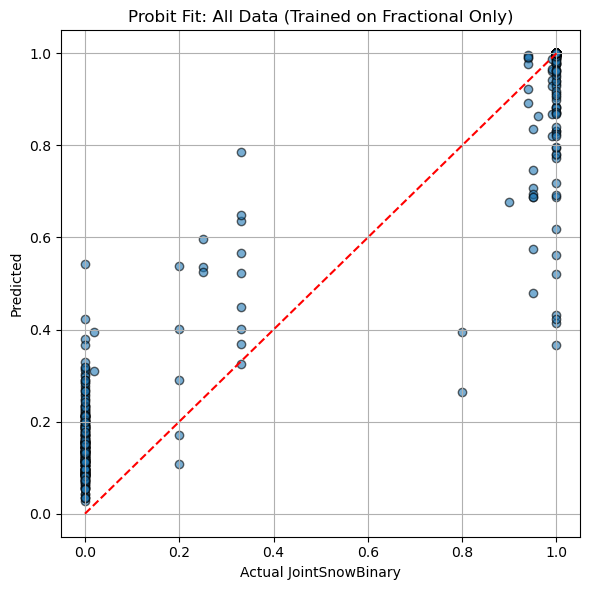

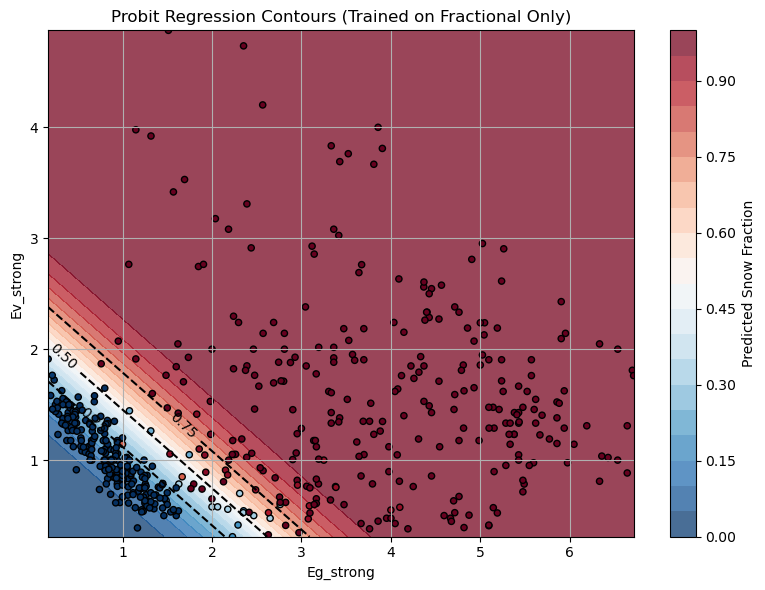

Overall RMSE: 0.1483
Overall Bias: 0.0465
Fractional RMSE: 0.2355
Fractional Bias: 0.0009
Classification Accuracy (4-bin): 47.89%

Confusion Matrix:
            [0,0.05)  [0.05,0.5)  [0.5,0.95)  [0.95,1]
[0,0.05)           6         208           1         0
[0.05,0.5)         0           8           9         0
[0.5,0.95)         0           2           5         4
[0.95,1]           0           5          43       231


In [4]:
from sklearn.metrics import mean_squared_error, confusion_matrix
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

# Drop missing
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "JointSnowBinary", "date"]).copy()

# Define fractional subset for training
train_frac = df[(df["JointSnowBinary"] > 0) & (df["JointSnowBinary"] < 1)].copy()

# Define predictors and target
X_train = sm.add_constant(train_frac[["Eg_strong", "Ev_strong"]])
y_train = train_frac["JointSnowBinary"]

# Train Probit model
model = sm.GLM(y_train, X_train, family=sm.families.Binomial(link=sm.families.links.Probit()))
result = model.fit()

# Predict on entire dataset
X_full = sm.add_constant(df[["Eg_strong", "Ev_strong"]])
y_full = df["JointSnowBinary"]
y_pred = result.predict(X_full)

# Binning
actual_bins = y_full.apply(fsc_bin)
pred_bins = pd.Series(y_pred, index=y_full.index).apply(fsc_bin)

# Classification accuracy
bin_accuracy = (actual_bins == pred_bins).mean()

# RMSE and bias
rmse = np.sqrt(mean_squared_error(y_full, y_pred))
bias = np.mean(y_pred - y_full)

# Fractional only RMSE and bias
mask_frac = (y_full > 0) & (y_full < 1)
frac_rmse = np.sqrt(mean_squared_error(y_full[mask_frac], y_pred[mask_frac]))
frac_bias = np.mean(y_pred[mask_frac] - y_full[mask_frac])

# Confusion matrix
bin_labels = ["[0,0.05)", "[0.05,0.5)", "[0.5,0.95)", "[0.95,1]"]
conf = confusion_matrix(actual_bins, pred_bins, labels=bin_labels)
conf_df = pd.DataFrame(conf, index=bin_labels, columns=bin_labels)

# Plot: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_full, y_pred, alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual JointSnowBinary")
plt.ylabel("Predicted")
plt.title("Probit Fit: All Data (Trained on Fractional Only)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Contour
eg_range = np.linspace(df["Eg_strong"].min(), df["Eg_strong"].max(), 300)
ev_range = np.linspace(df["Ev_strong"].min(), df["Ev_strong"].max(), 300)
Eg_grid, Ev_grid = np.meshgrid(eg_range, ev_range)

grid_df = pd.DataFrame({
    "const": 1,
    "Eg_strong": Eg_grid.ravel(),
    "Ev_strong": Ev_grid.ravel()
})
Z = result.predict(grid_df).values.reshape(Eg_grid.shape)

plt.figure(figsize=(8, 6))
contour = plt.contourf(Eg_grid, Ev_grid, Z, levels=np.linspace(0, 1, 21), cmap='RdBu_r', alpha=0.75)
cbar = plt.colorbar(contour)
cbar.set_label('Predicted Snow Fraction')

lines = plt.contour(Eg_grid, Ev_grid, Z, levels=[0, 0.25, 0.5, 0.75, 1], colors='k', linestyles='--')
plt.clabel(lines, fmt='%1.2f')
plt.scatter(df["Eg_strong"], df["Ev_strong"], c=y_full, cmap='RdBu_r', edgecolor='k', s=20)
plt.xlabel("Eg_strong")
plt.ylabel("Ev_strong")
plt.title("Probit Regression Contours (Trained on Fractional Only)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary
print(f"Overall RMSE: {rmse:.4f}")
print(f"Overall Bias: {bias:.4f}")
print(f"Fractional RMSE: {frac_rmse:.4f}")
print(f"Fractional Bias: {frac_bias:.4f}")
print(f"Classification Accuracy (4-bin): {bin_accuracy:.2%}")
print("\nConfusion Matrix:")
print(conf_df)


### Plotting fractional data

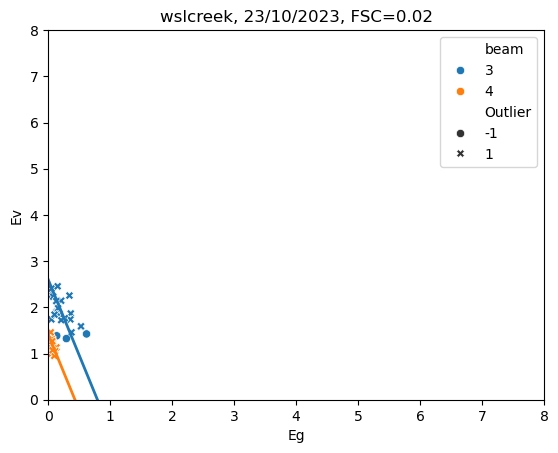

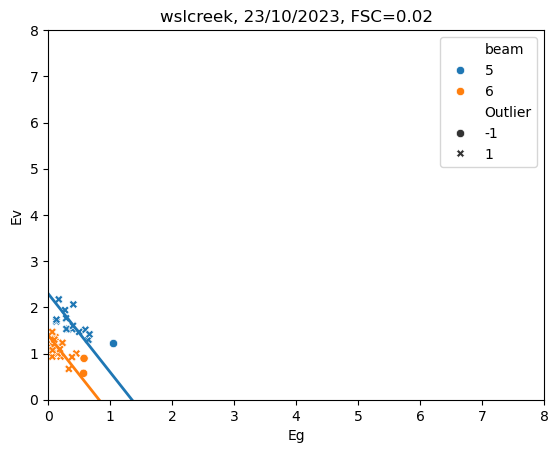

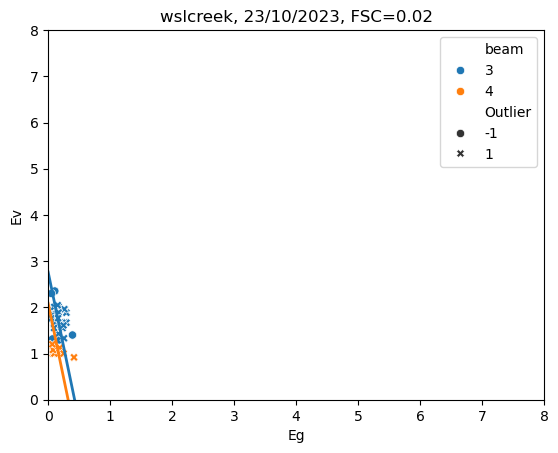

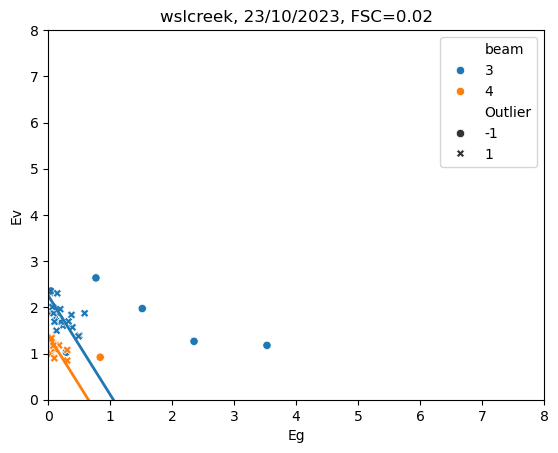

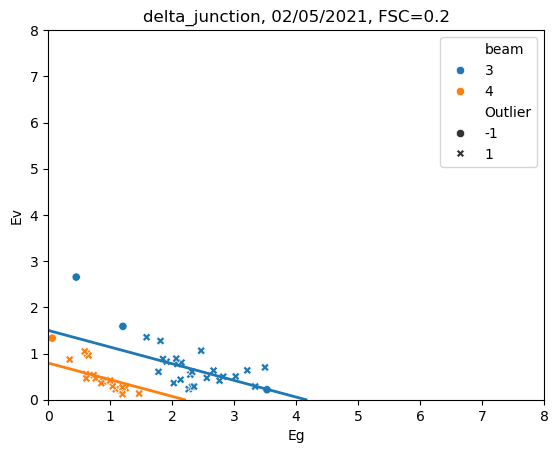

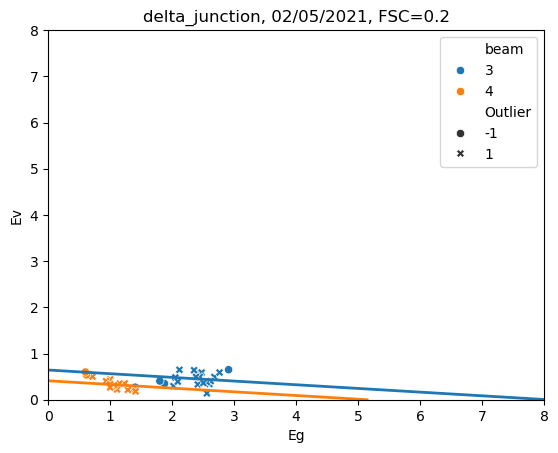

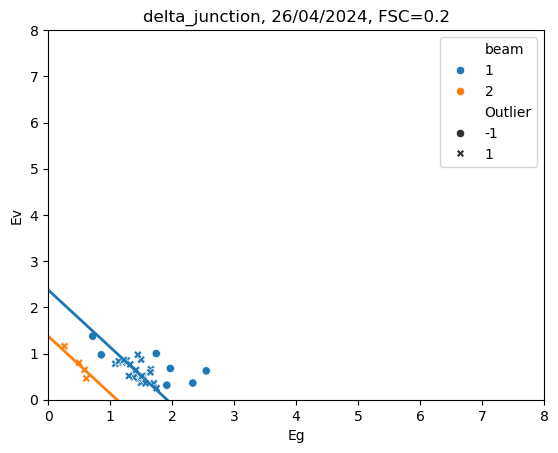

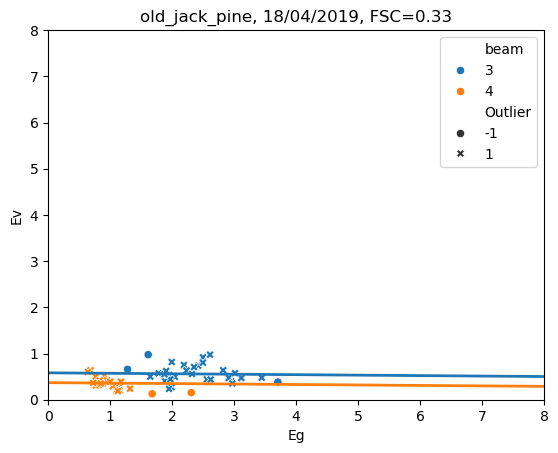

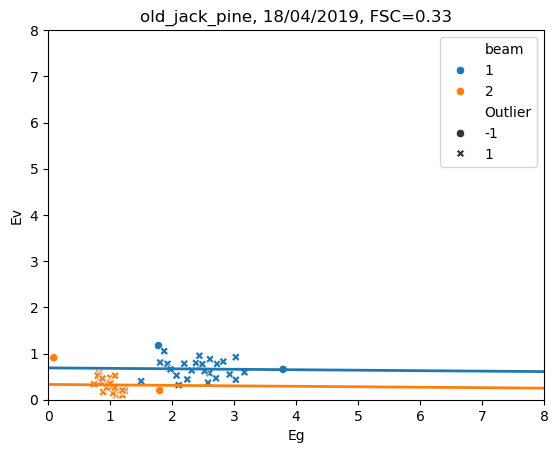

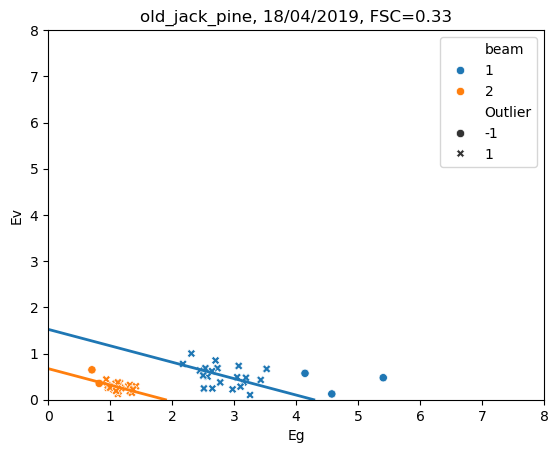

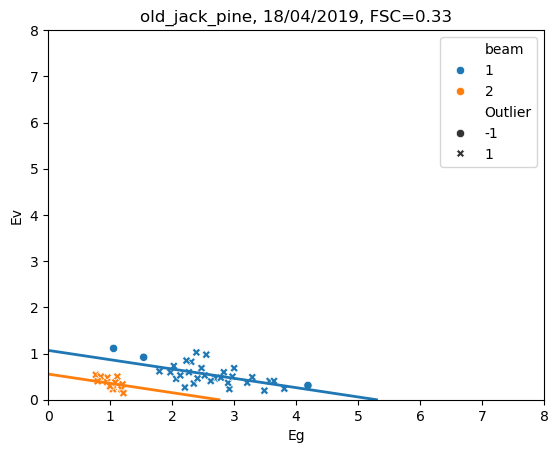

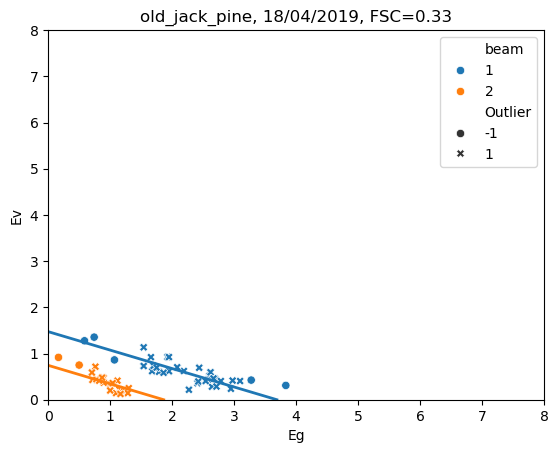

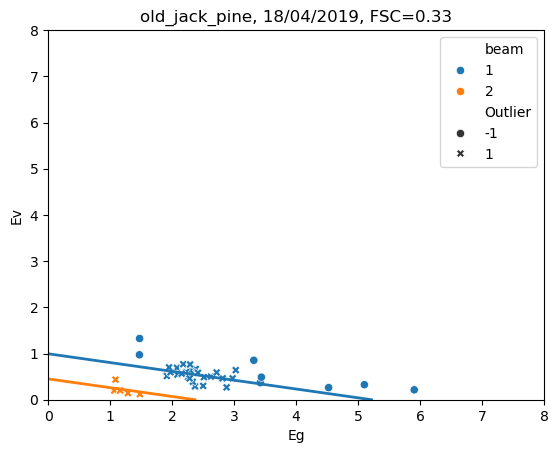

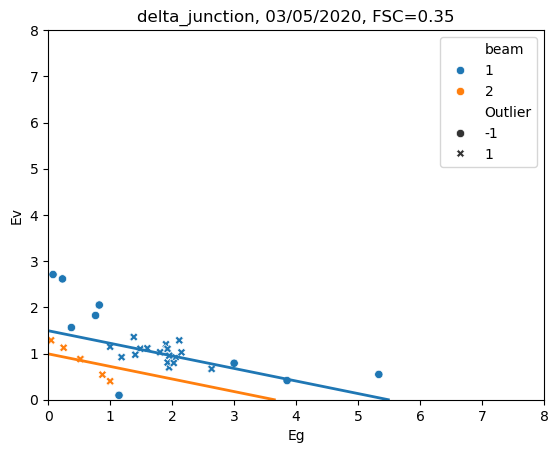

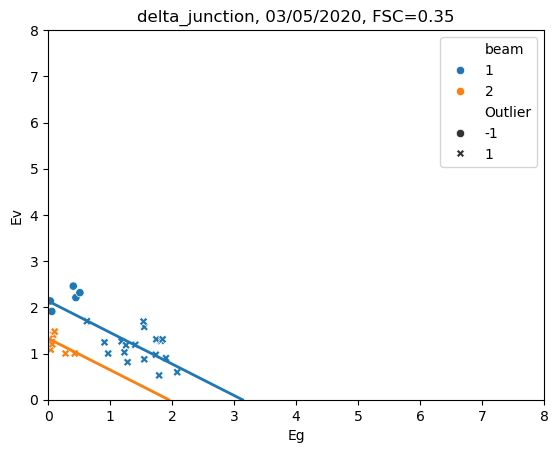

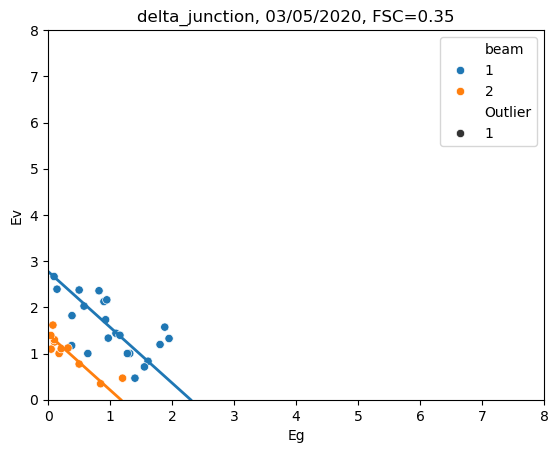

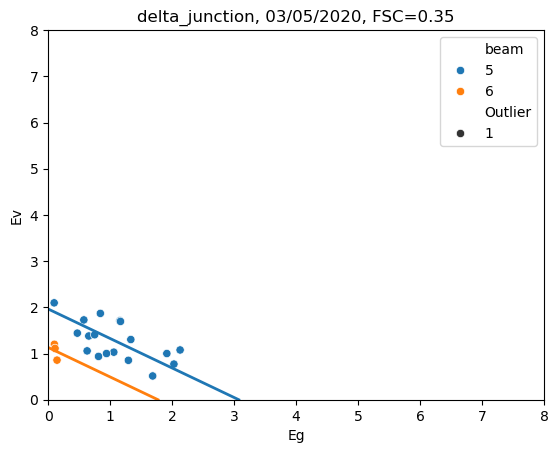

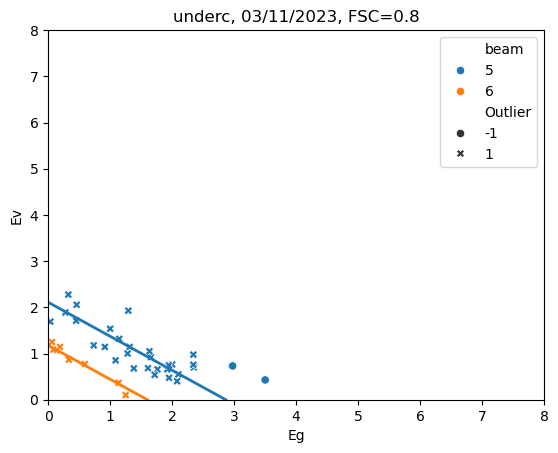

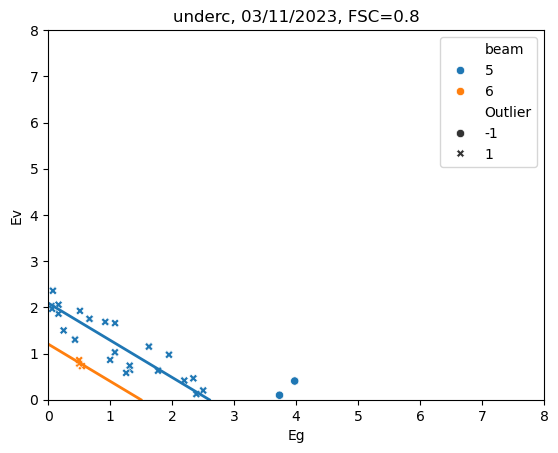

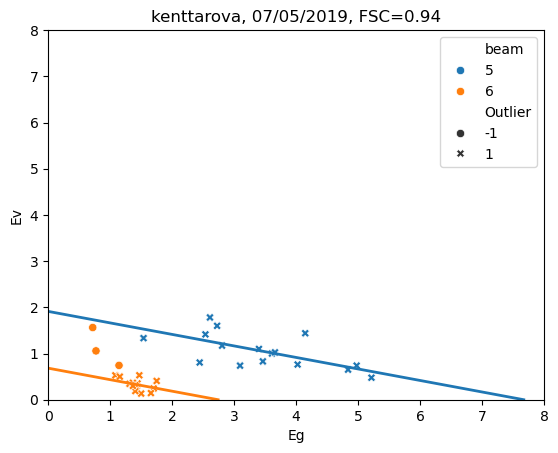

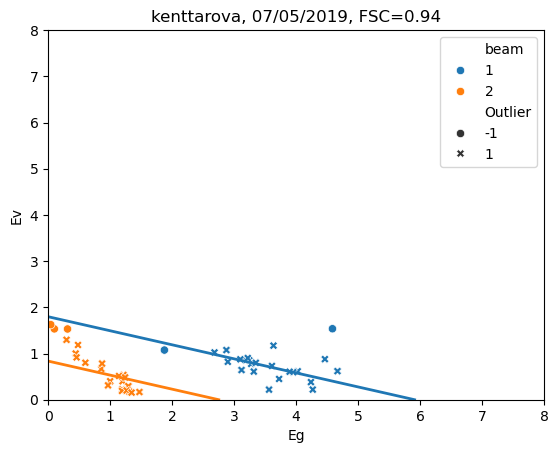

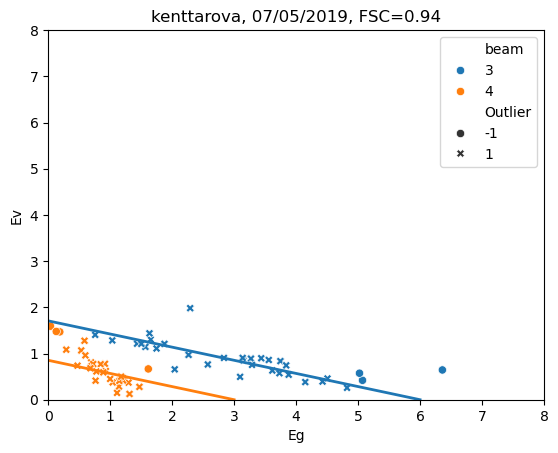

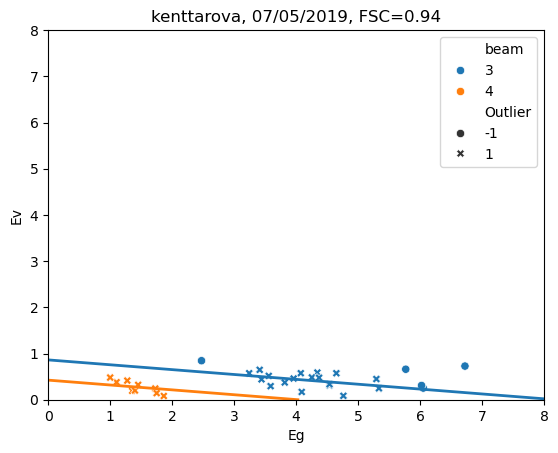

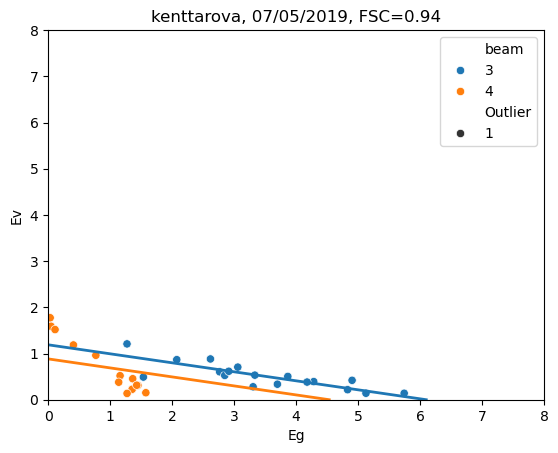

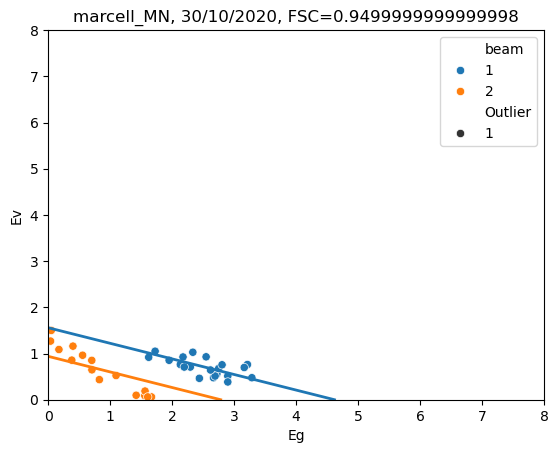

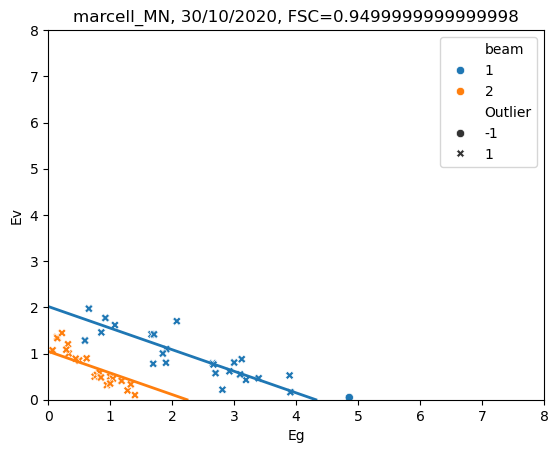

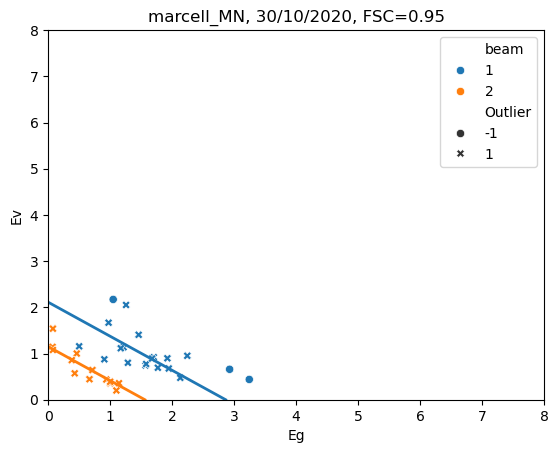

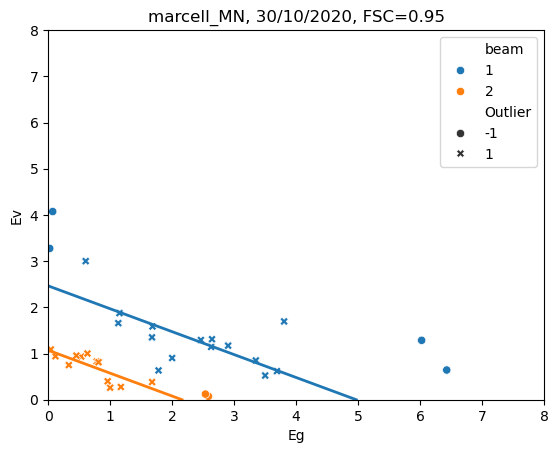

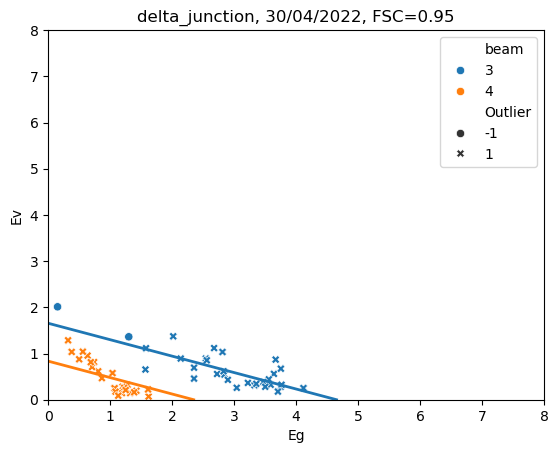

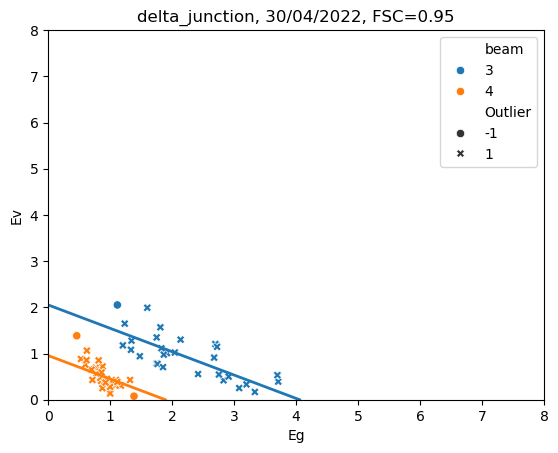

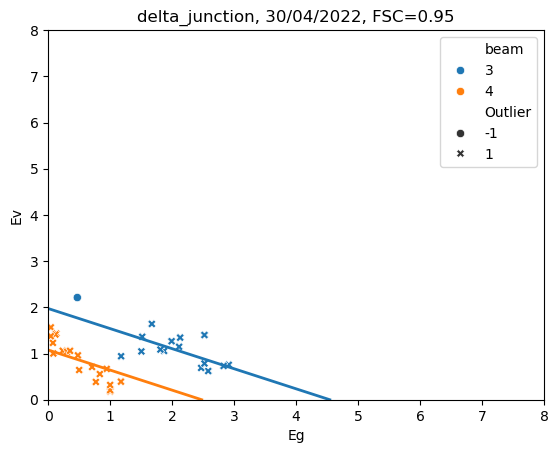

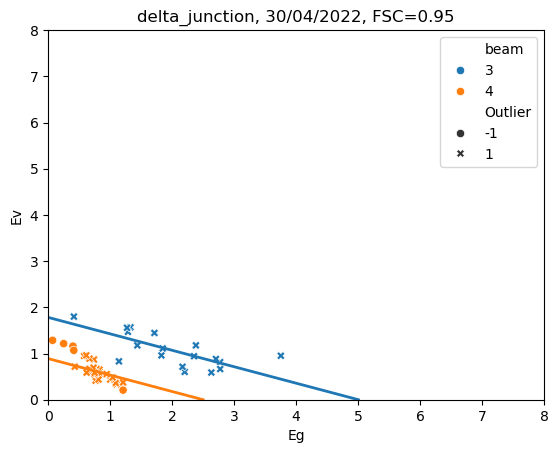

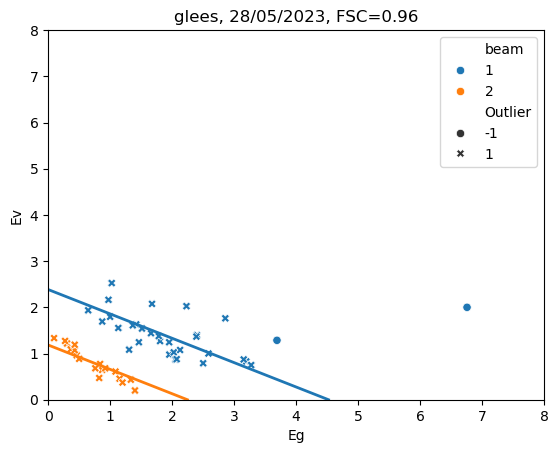

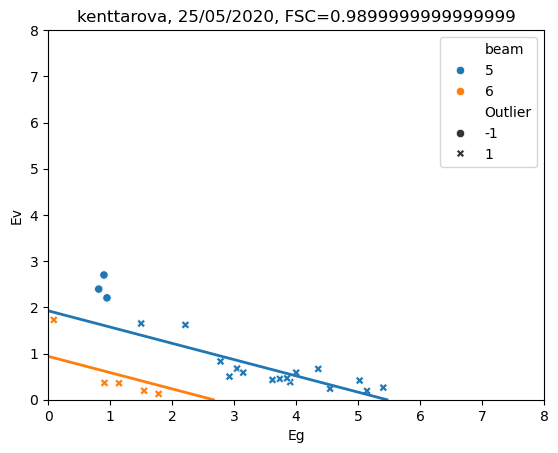

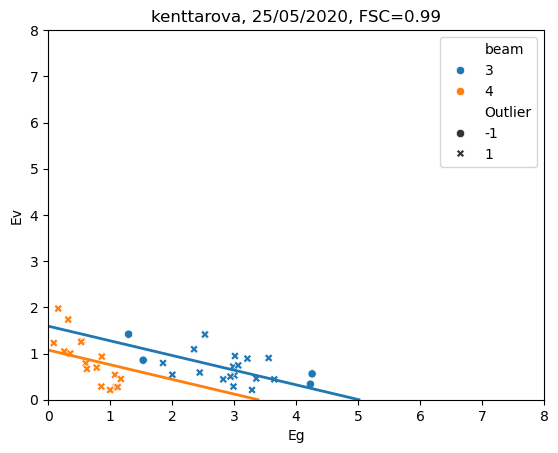

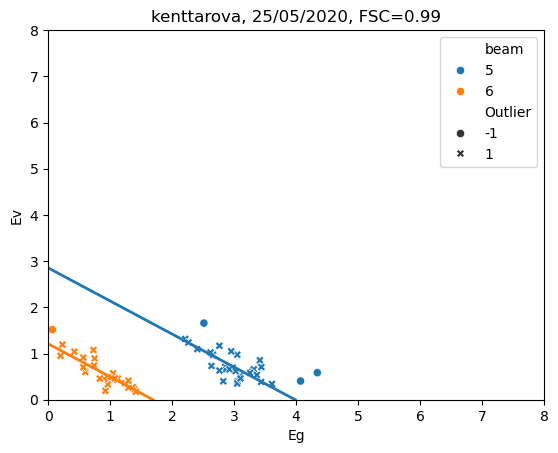

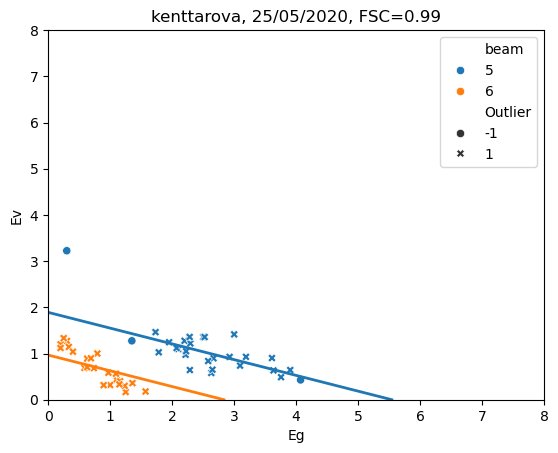

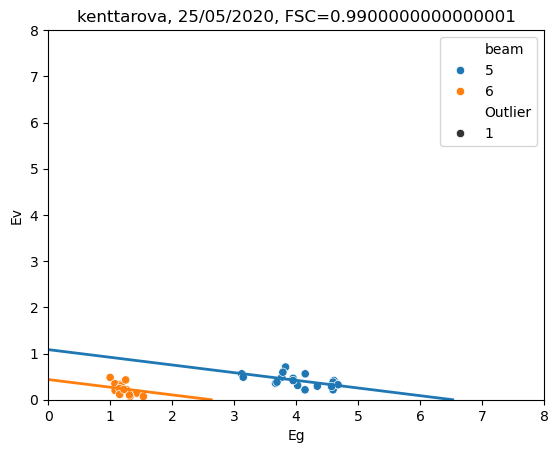

In [19]:
from scripts.parallel_blocks_WIP import *
    
# misclassified.columns
for idx, row in frac_data.sort_values('FSC').iterrows():
    plt.figure()
    plt.title(f"{row['camera']}, {row['date']}, FSC={row['FSC']}")
    
    test_plot = df[(df['camera'] == row['camera']) &
                   (df['date'] == row['date']) &
                   (df['lon'] == row['lon']) &
                   (df['lat'] == row['lat'])].copy()

    params, _, test = df_odr(test_plot, outlier_removal=10,w=[1, 0.25])

    # print(test)

    # Get sorted unique beams (hue order used by seaborn)
    beam_order = sorted(test['beam'].unique())

    # Create mapping from beam label to tab10 color
    tab10 = cm.get_cmap('tab10')
    color_map = {beam: tab10(i) for i, beam in enumerate(beam_order)}

    # Plot with fixed hue order and palette
    sns.scatterplot(data=test, x='Eg', y='Ev', hue='beam', style='Outlier',
                    hue_order=beam_order, palette=color_map)

    # Plot ODR lines in matching colors
    for b, beam in zip(params[1:], beam_order):
        plt.plot([0, -b / params[0]], [b, 0], color=color_map[beam], linewidth=2)

    plt.xlim(0, 8)
    plt.ylim(0, 8)
    plt.legend()
    plt.show()

    # break